# Data Science - Laboratorio 4
## Redes neuronales convolucionales (CNN) 
- - -
### Integrantes:
- Diego Alberto Leiva 21752
- José Pablo Orellana 21970
- - -

## Librerias

NOTA: Importante tener el Token de la API en el folder `C:\Users\<Windows-username>\.kaggle\kaggle.json`

Para una guia mas detallada o si tiene otro sistema dirigase a: https://www.kaggle.com/docs/api#getting-started-installation-&-authentication 

Asimismo puede visitar la documentacion oficial de la API: https://github.com/Kaggle/kaggle-api/tree/main/docs#api-credentials

In [9]:
# Kaggle API
import kaggle
from kaggle.rest import ApiException

# Operaciones de archivos
import os
import pickle
import zipfile

# Operaciones de datos
import pandas as pd
import numpy as np
from collections import defaultdict

# Operaciones de imágenes
from PIL import Image

# Visualización
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

# Utilidades
import random
import time
import uuid

# Pytorch y Torchvision
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.optim import lr_scheduler
from torchvision import transforms

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# Warnings
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Configuración de ruda de CUDA
# De no tener CUDA, comentar las siguiente línea
os.environ['CUDA_PATH'] = r"C:/Program Files/NVIDIA GPU Computing Toolkit//CUDA//v12.4"  # Ruta para CUDA 12.4

## Carga de Dataset

In [3]:
# Nombre del dataset y rutas
dataset_name = 'agungpambudi/mnist-multiple-dataset-comprehensive-analysis'     # Nombre del dataset
download_path = 'mnist-multiple-dataset-comprehensive-analysis.zip'             # Ruta de descarga
target_dir = 'dataset'                                                            # Directorio de destino

# Verificar si ya existe el directorio de destino
if not os.path.exists(target_dir):
    # Autenticar con la API de Kaggle
    kaggle.api.authenticate()

    try:
        # Descargar el dataset de Kaggle si no existe
        if not os.path.exists(download_path):
            kaggle.api.dataset_download_files(dataset=dataset_name,
                                              quiet=False, 
                                              unzip=False)
            print(f"EXITO: Dataset descargado como '{download_path}'.\n")

    # Manejo de errores
    except ApiException as e:
        print("ERROR al llamar a KaggleApi -> datasets_download: %s\n" % e)

    try:
        # Descomprimir únicamente la carpeta MMNIST
        with zipfile.ZipFile(download_path, 'r') as zip_ref:
            members = [m for m in zip_ref.namelist() if m.startswith('PolyMNIST/MMNIST/')]
            
            # Barra de progreso para la descompresión
            for member in tqdm(members, desc="Descomprimiendo archivos", unit=" archivo"):
                # Obtener el nombre del archivo relativo a MMNIST
                filename = os.path.relpath(member, 'PolyMNIST/MMNIST/')
                target_path = os.path.join(target_dir, filename)
                
                if not member.endswith('/'):
                    # Crear el directorio de destino si no existe
                    os.makedirs(os.path.dirname(target_path), exist_ok=True)
                    # Extraer el archivo
                    with zip_ref.open(member) as source, open(target_path, 'wb') as target:
                        target.write(source.read())

        # Eliminar el archivo ZIP después de la extracción
        os.remove(download_path)
        print(f"\nEXITO: Archivos de PolyMNIST descomprimidos en '{target_dir}'")

    except Exception as e:
        print("ERROR al descomprimir el dataset: %s\n" % e)

else:
    # Si ya existe el directorio, no hacer nada
    print(f"Carpeta {target_dir} ya existe. Se omite la descarga y la extracción.")

Dataset URL: https://www.kaggle.com/datasets/agungpambudi/mnist-multiple-dataset-comprehensive-analysis


100%|██████████| 874M/874M [00:39<00:00, 23.5MB/s] 



EXITO: Dataset descargado como 'mnist-multiple-dataset-comprehensive-analysis.zip'.



Descomprimiendo archivos: 100%|██████████| 350000/350000 [02:17<00:00, 2547.28 archivo/s]


EXITO: Archivos de PolyMNIST descomprimidos en 'dataset'


Se crea una instancia de la API de **Kaggle** y se autentica utilizando las credenciales proporcionadas por el Token generado en Kaggle. Posteriormente, se procede a descargar el conjunto de datos en formato comprimido (zip). Una vez completada la descarga, se extraen y descomprimen únicamente los archivos contenidos en la carpeta `PolyMNIST`, ubicándolos en una carpeta destino denominada **dataset**. Este procedimiento se realiza con el fin de evitar el procesamiento adicional de archivos que no serán relevantes para el laboratorio.

- En caso de que ocurra una excepción o error durante la descarga o la descompresión de archivos, se mostrará el mensaje de error correspondiente.
- Para evitar la repetición de la descarga y descompresión en cada ejecución del cuaderno, se verifica la existencia de la carpeta dataset. Si esta carpeta ya está presente, se asume que el proceso se ha completado satisfactoriamente en ejecuciones previas y se omite el proceso en futuras ejecuciones.

## Análisis Exploratorio

### Muestreo de Digitos

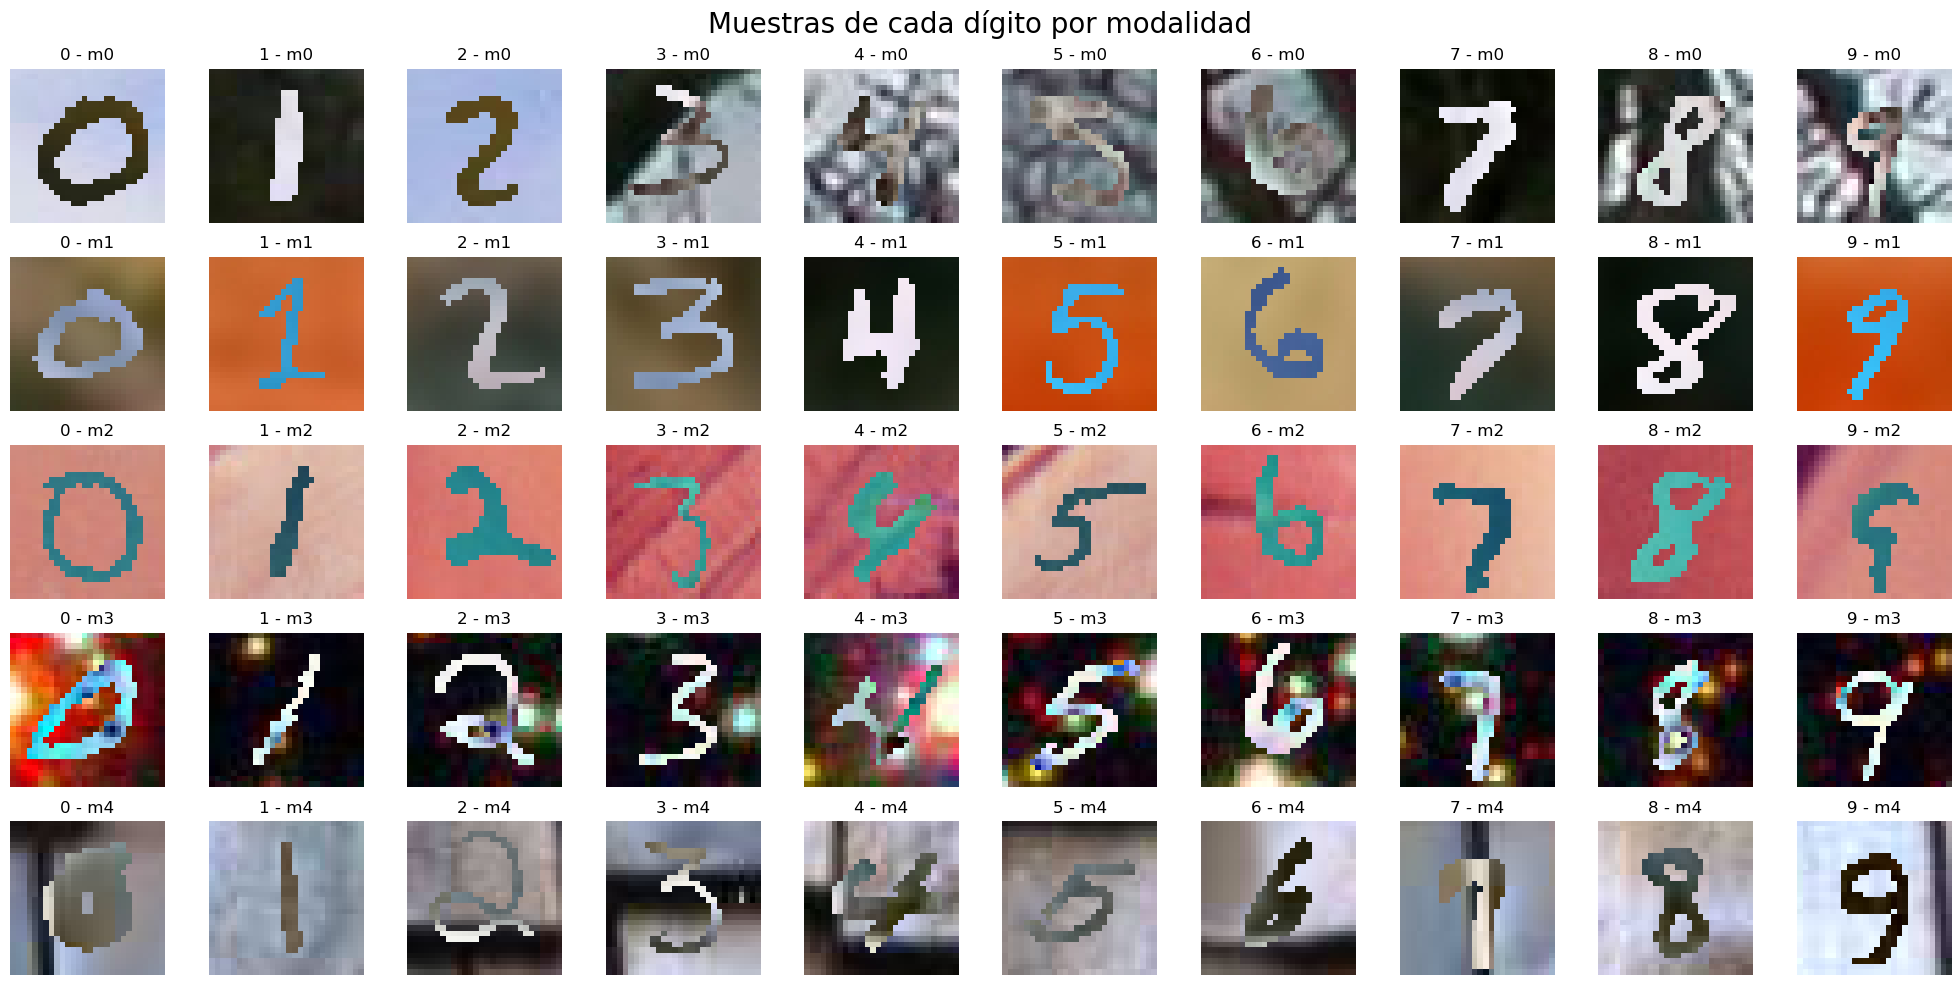

In [4]:
# Definir ruta del conjunto de entrenamiento
dataset_path = 'dataset/train'

# Modaliades de MMNIST
modalities = ['m0', 'm1', 'm2', 'm3', 'm4']

# Diccionario para almacenar muestras por modalidad
samples = {modality: {} for modality in modalities}

# Recorrer las modalidades
for modality in modalities:
    modality_path = os.path.join(dataset_path, modality)
    digits_sampled = set()
    
    # Recorrer las imágenes en la modalidad
    for img_name in os.listdir(modality_path):
        digit = img_name.split('.')[1]  # extraer el dígito
        
        # Si el dígito no ha sido muestreado, almacenar la imagen
        if digit not in digits_sampled:
            img_path = os.path.join(modality_path, img_name)
            image = Image.open(img_path)
            samples[modality][digit] = image
            digits_sampled.add(digit)

# Mostrar las imágenes muestreadas
fig, axes = plt.subplots(5, 10, figsize=(20, 10))
axes = axes.flatten()

for i, modality in enumerate(modalities):
    for j, digit in enumerate(sorted(samples[modality].keys())):
        axes[i*10 + j].imshow(samples[modality][digit], cmap='gray')
        axes[i*10 + j].set_title(f'{digit} - {modality}')
        axes[i*10 + j].axis('off')

plt.suptitle('Muestras de cada dígito por modalidad', fontsize=20)
plt.tight_layout()
plt.show()

Al examinar las imágenes de dígitos en cada modalidad (específicamente para el conjunto de datos de entrenamiento), se observa que los dígitos están superpuestos sobre diversos fondos similares para cada modalidad. Esto confirma que cada modalidad está compuesta por parches aleatorios recortados de una imagen más grande, en la que el dígito está colocado en el centro. La muestra sugiere que los dígitos se colocan en el centro de la imagen y que estas imágenes tienen una relación de aspecto **1:1** (cuadradas).

### Distribuciones de Imágenes

In [5]:
def count_images_by_digit_and_mode(dataset_path, modes = ['train', 'test']):
    """
    Contar el número de imágenes por dígito y modo (entrenamiento o prueba).

    Args:
        dataset_path (str): Ruta del conjunto de datos.

    Returns:
        pd.DataFrame: DataFrame con el conteo de imágenes por dígito y modo.
    """
    data = []
    
    for mode in modes:
        mode_path = os.path.join(dataset_path, mode)
        for modality in modalities:
            modality_path = os.path.join(mode_path, modality)
            for img_name in os.listdir(modality_path):
                digit = img_name.split('.')[1]
                data.append((mode, modality, digit))
    
    df = pd.DataFrame(data, columns=['mode', 'modality', 'digit'])
    return df

#### Distribución de imágenes por modalidad

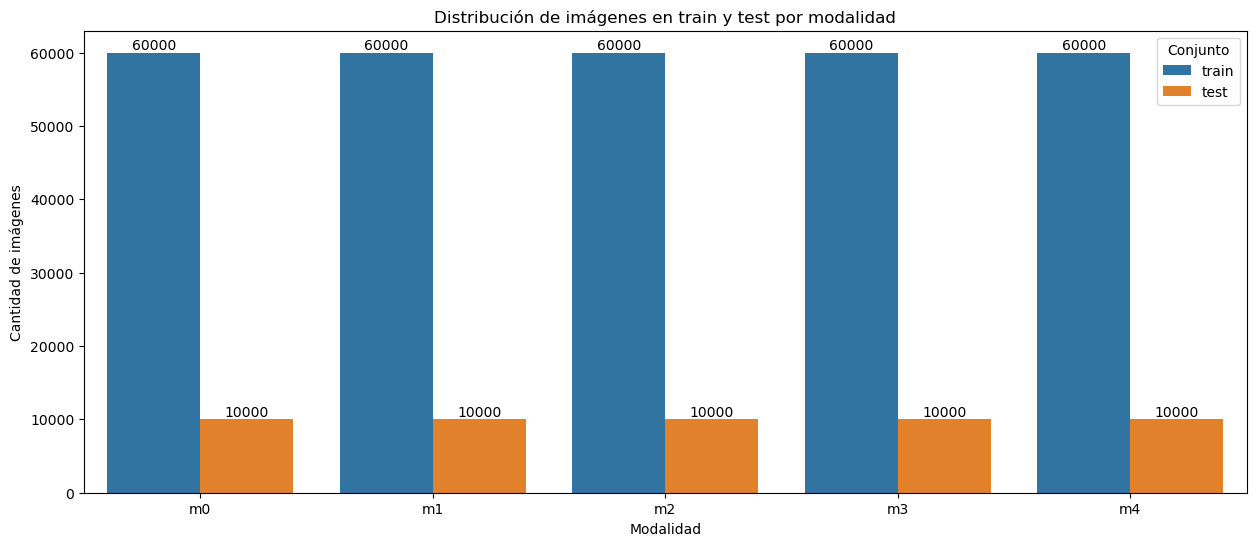

In [6]:
# Contar las imágenes por dígito y modalidad
df_counts = count_images_by_digit_and_mode('dataset')

# Graficar la distribución de imágenes en train y test por modalidad
plt.figure(figsize=(15, 6))
ax = sns.countplot(data=df_counts, x='modality', hue='mode')

# Etiquetas en las barras con la cantidad de imágenes
for container in ax.containers:
    ax.bar_label(container)

# Configuración de la gráfica
plt.title('Distribución de imágenes en train y test por modalidad')
plt.legend(title='Conjunto')
plt.xlabel('Modalidad')
plt.ylabel('Cantidad de imágenes')
plt.show()

El gráfico presentado indica que tanto el conjunto de entrenamiento como el de prueba contienen una cantidad uniforme de imágenes en cada modalidad, lo que sugiere un equilibrio en términos de número total de imágenes. Sin embargo, es necesario verificar el equilibrio en la representación de los dígitos. La falta de balance en la representación de los dígitos podría introducir un sesgo hacia aquellos dígitos con una mayor cantidad de representaciones.

#### Distribución de imágenes por dígitos

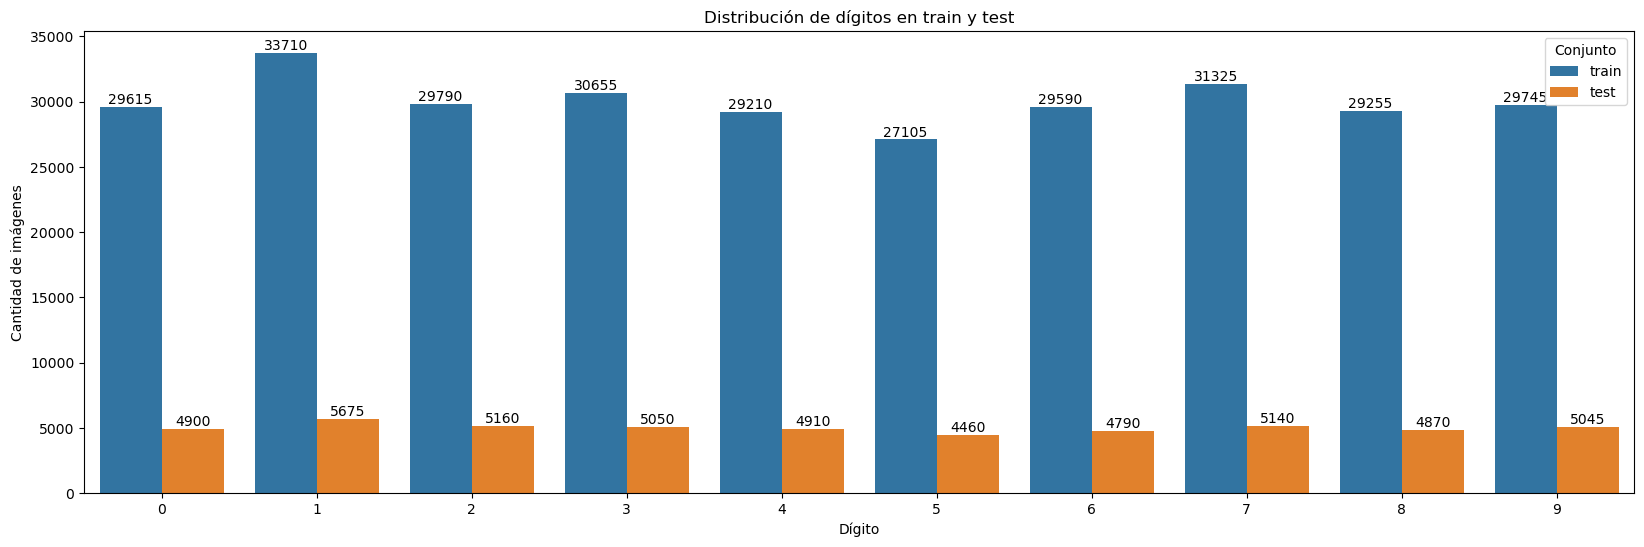

In [7]:
# Graficar la distribución de dígitos en general en train y test
plt.figure(figsize=(20, 6))
ax = sns.countplot(data=df_counts, x='digit', hue='mode')

# Etiquetas en las barras con la cantidad de imágenes
for container in ax.containers:
    ax.bar_label(container)

# Configuración de la gráfica
plt.title('Distribución de dígitos en train y test')
plt.legend(title='Conjunto', loc='upper right')
plt.xlabel('Dígito')
plt.ylabel('Cantidad de imágenes')
plt.show()

Como se anticipaba en la etapa anterior, se ha confirmado que no todos los dígitos tienen una representación equitativa. Los dígitos `1` y `7` presentan una mayor representación, mientras que el dígito `5` tiene una menor representación. El reso de dígitos se encuentran en un rango de **29,000-30,000** imágenes. Esto sugiere la necesidad de aplicar una técnica de balanceo de clases para asegurar una representación uniforme de todos los dígitos en el conjunto de entrenamiento. El equilibrio de clases en el conjunto de prueba no es crítico, ya que estos datos no influyen directamente en el entrenamiento del modelo.

Existen tres estrategias para el balanceo de clases:
- **Oversampling**: Consiste en duplicar las imágenes de los dígitos menos representados para alcanzar el equilibrio de clases, aunque esto podría introducir sesgos hacia las imágenes duplicadas.
- **Undersampling**: Implica eliminar imágenes de los dígitos sobre-representados para lograr el equilibrio, siendo esta estrategia más adecuada cuando se dispone de una gran cantidad de datos.
- **Data Augmentation**: Aplicación de transformaciones a las imágenes para generar nuevas muestras y completar las clases menos representadas, sin pérdida ni duplicación de información, lo que la convierte en una opción ideal.

Para determinar la estrategia más efectiva, es necesario evaluar el balance de clases en cada modalidad por separado, permitiendo así un análisis más detallado de las variaciones en la representación de dígitos en cada modalidad y seleccionar la estrategia más adecuada.

#### Distribución de dígitos por modalidad

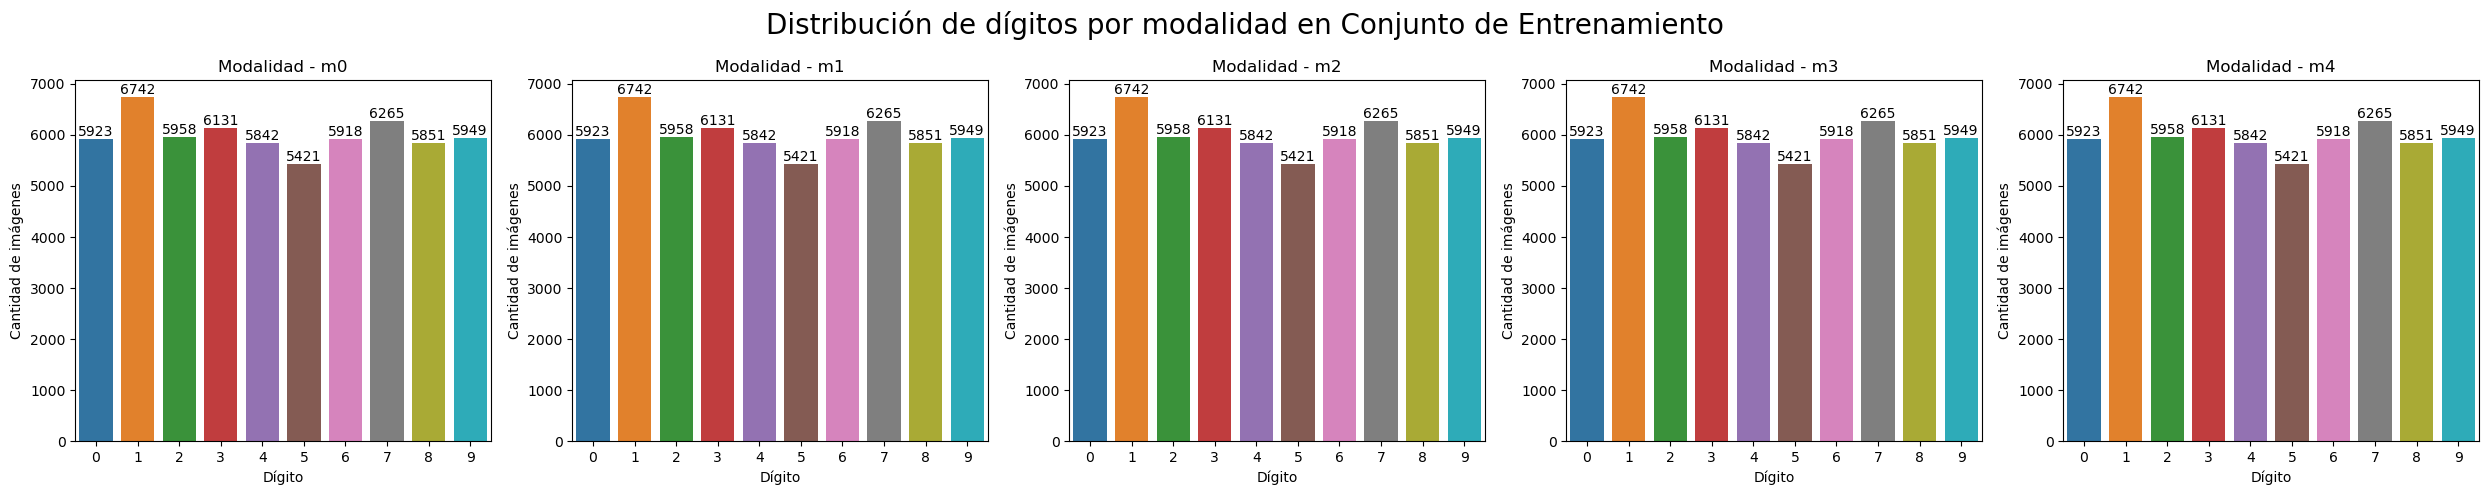

In [8]:
# Graficar la distribución de dígitos por modalidad en el set de entrenamiento
fig, axes = plt.subplots(1, 5, figsize=(25, 5))

# Recorrer las modalidades
for i, modality in enumerate(modalities):
    # Graficar la distribución de dígitos en entrenamiento por modalidad
    ax = sns.countplot(data=df_counts[(df_counts['modality'] == modality) & (df_counts['mode'] == 'train')],
                  x='digit', ax=axes[i], hue='digit')
    
    # Etiquetas en las barras con la cantidad de imágenes
    for container in ax.containers:
        ax.bar_label(container)
    
    # Configuración de la gráfica
    axes[i].set_title(f'Modalidad - {modality}')
    axes[i].set_ylabel('Cantidad de imágenes')
    axes[i].set_xlabel('Dígito')

# Configuración de la gráfica general
plt.suptitle('Distribución de dígitos por modalidad en Conjunto de Entrenamiento', fontsize=20)
plt.tight_layout()
plt.show()

Con un análisis más detallado, se observa que cada modalidad presenta un conteo uniforme de dígitos, pero con un desequilibrio en la representación. En todos los casos, el dígito `1` es el más representado con más de **6,700** imágenes, seguido por el dígito `7` con más de **6,200** imágenes. El dígito `5` es el menos representado en todos los casos con **5,400** imágenes. El dígito `3` es el tercer dígito más representado, con un conteo de **6,100** imágenes. Los restantes dígitos tienen valores cercanos a **5,800-5,900** imágenes.

#### Resolución de Imágenes y Relación Aspecto

In [9]:
def get_image_size(dataset_path):
    """
    Obtener las dimensiones de las imágenes en el conjunto de datos.
    
    Args:
        dataset_path (str): Ruta del conjunto de datos.
    
    Returns:
        dict: Diccionario con las dimensiones de las imágenes por modalidad y modo.
    """
    image_shapes = {}  # Diccionario para almacenar las dimensiones de las imágenes
    
    # Recorrer los set de datos y modalidades
    for mode in ['train', 'test']:
        # Generar la ruta del set de datos
        mode_path = os.path.join(dataset_path, mode)

        # Recorrer las modalidades
        for modality in modalities:
            # Generar la ruta de la modalidad y obtener las imágenes
            modality_path = os.path.join(mode_path, modality)
            image_files = os.listdir(modality_path)

            # Recorrer las imágenes
            for img_name in tqdm(image_files, desc=f'Obteniendo dimensiones de {modality} en {mode}', unit=' imagen'):
                img_path = os.path.join(modality_path, img_name)
                
                # Abrir la imagen y obtener sus dimensiones
                with Image.open(img_path) as img:
                    width, height = img.size
                    # Almacenar las dimensiones en el diccionario
                    if (mode, modality) not in image_shapes:
                        image_shapes[(mode, modality)] = []
                    image_shapes[(mode, modality)].append((width, height))
    
    # Retornar las dimensiones de las imágenes
    return image_shapes

In [10]:
def save_image_shapes(image_shapes, data_path):
    """
    Guardar las dimensiones de las imágenes en un archivo pickle.

    Args:
        image_shapes (dict): Diccionario con las dimensiones de las imágenes.
        data_path (str): Ruta donde se guardará el archivo pickle.
    
    Returns:
        None
    """
    with open(data_path, 'wb') as f:
        pickle.dump(image_shapes, f)


def load_image_shapes(data_path):
    """
    Cargar las dimensiones de las imágenes desde un archivo pickle.

    Args:
        data_path (str): Ruta del archivo pickle.
    
    Returns:
        dict: Diccionario con las dimensiones de las imágenes.
    """
    with open(data_path, 'rb') as f:
        return pickle.load(f)

In [11]:
image_shapes_path = 'data/image_shapes.pkl'
# Revisar si ya se ha procesado la información de las imágenes
if os.path.exists(image_shapes_path):
    try:
        print("Cargando las dimensiones de las imágenes desde archivo...")
        image_shapes = load_image_shapes(image_shapes_path)
        print("\nEXITO: Dimensiones de las imágenes cargadas.")
    except Exception as e:
        print(f"ERROR al cargar las dimensiones de las imágenes desde archivo: {e}")
else:
    print("Procesando las dimensiones de las imágenes...")
    try:
        image_shapes = get_image_size('dataset')
        print("\nEXITO: Dimensiones de las imágenes procesadas.")
        
        # Guardar las dimensiones de las imágenes
        os.makedirs(os.path.dirname(image_shapes_path), exist_ok=True)
        save_image_shapes(image_shapes, image_shapes_path)
        print("\nEXITO: Dimensiones de las imágenes guardadas en archivo.")
    except Exception as e:
        print(f"\nERROR al procesar las dimensiones de las imágenes: {e}")

Procesando las dimensiones de las imágenes...


Obteniendo dimensiones de m4 en test: 100%|██████████| 10000/10000 [00:29<00:00, 340.78 imagen/s]



EXITO: Dimensiones de las imágenes procesadas.

EXITO: Dimensiones de las imágenes guardadas en archivo.


Para evitar tener que obtener las dimensiones de todas las imágenes dentro del conjunto de datos, se crea un archivo `pickle`. De esta manera al ejecutar nuevamente el notebook solo se carga la información guardada en el archivo en lugar de abrir y obtener las dimensiones de cada imágen, cosa que toma alrededor de 20 minutos en un equipo con procesador intel core i9.

In [12]:
# Mostrar las dimensiones de las imágenes por modalidad y conjunto
for (mode, modality), shapes in image_shapes.items():
    print(f"Dimensiones de imágenes con {modality} en {mode}:")
    size_counts = {}
    for width, height in shapes:
        size = (width, height)
        if size not in size_counts:
            size_counts[size] = 0
        size_counts[size] += 1
    
    for size, count in size_counts.items():
        print(f"\tResolución {size[0]}x{size[1]}: {count} imágenes")
    print()

Dimensiones de imágenes con m0 en train:
	Resolución 28x28: 60000 imágenes

Dimensiones de imágenes con m1 en train:
	Resolución 28x28: 60000 imágenes

Dimensiones de imágenes con m2 en train:
	Resolución 28x28: 60000 imágenes

Dimensiones de imágenes con m3 en train:
	Resolución 28x28: 60000 imágenes

Dimensiones de imágenes con m4 en train:
	Resolución 28x28: 60000 imágenes

Dimensiones de imágenes con m0 en test:
	Resolución 28x28: 10000 imágenes

Dimensiones de imágenes con m1 en test:
	Resolución 28x28: 10000 imágenes

Dimensiones de imágenes con m2 en test:
	Resolución 28x28: 10000 imágenes

Dimensiones de imágenes con m3 en test:
	Resolución 28x28: 10000 imágenes

Dimensiones de imágenes con m4 en test:
	Resolución 28x28: 10000 imágenes



Esto indica que todas las imágenes en el conjunto de datos tienen una resolución uniforme de 28 x 28 píxeles. Por lo tanto, no es necesario ajustar las dimensiones de las imágenes, ya que son consistentes. Sin embargo, se podría considerar reducir la resolución de las imágenes a 20 x 20 o incluso 10 x 10 para acelerar el proceso de entrenamiento.

## Preprocesamiento

### Balanceo de Clases

Para manejar el desbalance de clases en el conjunto de datos, se ha decidido aplicar **undersampling** al conjunto de datos de entrenamiento. 

Dado que el conjunto de datos cuenta con un número variable de imágenes por dígito y por cuestiones de procesamiento computacional en un dataset tan amplio como `PolyMNIST`, el undersampling proporciona una solución más simple y eficiente para equilibrar las clases sin complicar el proceso inicial. 

Se reducirá el número de imágenes a **5,000** por dígito en cada modalidad, resultando en un total de **25,000** imágenes por dígito en el conjunto de entrenamiento. 
A pesar de la reducción en el número total de imágenes mediante undersampling, el conjunto de datos resultante sigue siendo considerablemente grande y representativo. Esto representa más del **80%** del conjunto de datos original, conservando una cantidad significativa de información para el entrenamiento del modelo.

Esto permitirá que el procesamiento sea más manejable y evitará problemas potenciales con duplicados en aplicaciones futuras de data augmentation. 

In [13]:
def undersample_dataset(dataset_path, target_count=5000):
    modalities = ['m0', 'm1', 'm2', 'm3', 'm4']
    digits = [str(i) for i in range(10)]  # Dígitos del 0 al 9

    for modality in modalities:
        print(f"Procesando modalidad: {modality}...")
        for digit in digits:
            digit_path = os.path.join(dataset_path, modality)
            image_files = [f for f in os.listdir(digit_path) if f.split('.')[1] == digit]
            
            if len(image_files) > target_count:
                print(f"Submuestreando dígito {digit}: {len(image_files)} -> {target_count}")
                random.shuffle(image_files)
                files_to_remove = image_files[target_count:]  # Archivos a eliminar
                
                # Usar tqdm para mostrar la barra de progreso mientras eliminamos archivos
                for file in tqdm(files_to_remove, desc=f'Removing excess {digit}', unit=' imagen'):
                    os.remove(os.path.join(digit_path, file))
            else:
                print(f"Omitiendo dígito '{digit}' (no se requiere undersampling).")

        print(f"Modalidad {modality} procesada.\n")

In [14]:
# Ejecutar el undersampling
undersample_dataset('dataset/train')

Procesando modalidad: m0...
Submuestreando dígito 0: 5923 -> 5000


Removing excess 0: 100%|██████████| 923/923 [00:00<00:00, 9746.88 imagen/s]


Submuestreando dígito 1: 6742 -> 5000


Removing excess 1: 100%|██████████| 1742/1742 [00:00<00:00, 12981.70 imagen/s]


Submuestreando dígito 2: 5958 -> 5000


Removing excess 2: 100%|██████████| 958/958 [00:00<00:00, 12198.33 imagen/s]


Submuestreando dígito 3: 6131 -> 5000


Removing excess 3: 100%|██████████| 1131/1131 [00:00<00:00, 12701.20 imagen/s]


Submuestreando dígito 4: 5842 -> 5000


Removing excess 4: 100%|██████████| 842/842 [00:00<00:00, 12288.16 imagen/s]


Submuestreando dígito 5: 5421 -> 5000


Removing excess 5: 100%|██████████| 421/421 [00:00<00:00, 12756.10 imagen/s]


Submuestreando dígito 6: 5918 -> 5000


Removing excess 6: 100%|██████████| 918/918 [00:00<00:00, 11542.92 imagen/s]


Submuestreando dígito 7: 6265 -> 5000


Removing excess 7: 100%|██████████| 1265/1265 [00:00<00:00, 12104.84 imagen/s]


Submuestreando dígito 8: 5851 -> 5000


Removing excess 8: 100%|██████████| 851/851 [00:00<00:00, 11151.82 imagen/s]


Submuestreando dígito 9: 5949 -> 5000


Removing excess 9: 100%|██████████| 949/949 [00:00<00:00, 12195.32 imagen/s]


Modalidad m0 procesada.

Procesando modalidad: m1...
Submuestreando dígito 0: 5923 -> 5000


Removing excess 0: 100%|██████████| 923/923 [00:00<00:00, 8973.18 imagen/s]


Submuestreando dígito 1: 6742 -> 5000


Removing excess 1: 100%|██████████| 1742/1742 [00:00<00:00, 12261.74 imagen/s]

Submuestreando dígito 2: 5958 -> 5000



Removing excess 2: 100%|██████████| 958/958 [00:00<00:00, 11970.41 imagen/s]


Submuestreando dígito 3: 6131 -> 5000


Removing excess 3: 100%|██████████| 1131/1131 [00:00<00:00, 12559.79 imagen/s]


Submuestreando dígito 4: 5842 -> 5000


Removing excess 4: 100%|██████████| 842/842 [00:00<00:00, 12602.83 imagen/s]


Submuestreando dígito 5: 5421 -> 5000


Removing excess 5: 100%|██████████| 421/421 [00:00<00:00, 12200.24 imagen/s]


Submuestreando dígito 6: 5918 -> 5000


Removing excess 6: 100%|██████████| 918/918 [00:00<00:00, 12155.18 imagen/s]


Submuestreando dígito 7: 6265 -> 5000


Removing excess 7: 100%|██████████| 1265/1265 [00:00<00:00, 11982.97 imagen/s]


Submuestreando dígito 8: 5851 -> 5000


Removing excess 8: 100%|██████████| 851/851 [00:00<00:00, 11705.29 imagen/s]


Submuestreando dígito 9: 5949 -> 5000


Removing excess 9: 100%|██████████| 949/949 [00:00<00:00, 11858.24 imagen/s]

Modalidad m1 procesada.

Procesando modalidad: m2...


Submuestreando dígito 0: 5923 -> 5000


Removing excess 0: 100%|██████████| 923/923 [00:00<00:00, 12905.42 imagen/s]


Submuestreando dígito 1: 6742 -> 5000


Removing excess 1: 100%|██████████| 1742/1742 [00:00<00:00, 12778.97 imagen/s]


Submuestreando dígito 2: 5958 -> 5000


Removing excess 2: 100%|██████████| 958/958 [00:00<00:00, 12856.87 imagen/s]


Submuestreando dígito 3: 6131 -> 5000


Removing excess 3: 100%|██████████| 1131/1131 [00:00<00:00, 12629.71 imagen/s]


Submuestreando dígito 4: 5842 -> 5000


Removing excess 4: 100%|██████████| 842/842 [00:00<00:00, 10204.32 imagen/s]


Submuestreando dígito 5: 5421 -> 5000


Removing excess 5: 100%|██████████| 421/421 [00:00<00:00, 3379.20 imagen/s]


Submuestreando dígito 6: 5918 -> 5000


Removing excess 6: 100%|██████████| 918/918 [00:00<00:00, 13496.91 imagen/s]


Submuestreando dígito 7: 6265 -> 5000


Removing excess 7: 100%|██████████| 1265/1265 [00:00<00:00, 13092.74 imagen/s]


Submuestreando dígito 8: 5851 -> 5000


Removing excess 8: 100%|██████████| 851/851 [00:00<00:00, 11753.20 imagen/s]


Submuestreando dígito 9: 5949 -> 5000


Removing excess 9: 100%|██████████| 949/949 [00:00<00:00, 13536.04 imagen/s]


Modalidad m2 procesada.

Procesando modalidad: m3...
Submuestreando dígito 0: 5923 -> 5000


Removing excess 0: 100%|██████████| 923/923 [00:00<00:00, 12996.36 imagen/s]


Submuestreando dígito 1: 6742 -> 5000


Removing excess 1: 100%|██████████| 1742/1742 [00:00<00:00, 12123.29 imagen/s]


Submuestreando dígito 2: 5958 -> 5000


Removing excess 2: 100%|██████████| 958/958 [00:00<00:00, 13174.80 imagen/s]


Submuestreando dígito 3: 6131 -> 5000


Removing excess 3: 100%|██████████| 1131/1131 [00:00<00:00, 12918.27 imagen/s]


Submuestreando dígito 4: 5842 -> 5000


Removing excess 4: 100%|██████████| 842/842 [00:00<00:00, 12364.04 imagen/s]


Submuestreando dígito 5: 5421 -> 5000


Removing excess 5: 100%|██████████| 421/421 [00:00<00:00, 11849.11 imagen/s]


Submuestreando dígito 6: 5918 -> 5000


Removing excess 6: 100%|██████████| 918/918 [00:00<00:00, 12837.39 imagen/s]


Submuestreando dígito 7: 6265 -> 5000


Removing excess 7: 100%|██████████| 1265/1265 [00:00<00:00, 12152.08 imagen/s]


Submuestreando dígito 8: 5851 -> 5000


Removing excess 8: 100%|██████████| 851/851 [00:00<00:00, 7270.77 imagen/s]


Submuestreando dígito 9: 5949 -> 5000


Removing excess 9: 100%|██████████| 949/949 [00:00<00:00, 12480.07 imagen/s]


Modalidad m3 procesada.

Procesando modalidad: m4...
Submuestreando dígito 0: 5923 -> 5000


Removing excess 0: 100%|██████████| 923/923 [00:00<00:00, 13132.68 imagen/s]


Submuestreando dígito 1: 6742 -> 5000


Removing excess 1: 100%|██████████| 1742/1742 [00:00<00:00, 12844.27 imagen/s]


Submuestreando dígito 2: 5958 -> 5000


Removing excess 2: 100%|██████████| 958/958 [00:00<00:00, 13029.63 imagen/s]


Submuestreando dígito 3: 6131 -> 5000


Removing excess 3: 100%|██████████| 1131/1131 [00:00<00:00, 12773.36 imagen/s]


Submuestreando dígito 4: 5842 -> 5000


Removing excess 4: 100%|██████████| 842/842 [00:00<00:00, 13051.06 imagen/s]


Submuestreando dígito 5: 5421 -> 5000


Removing excess 5: 100%|██████████| 421/421 [00:00<00:00, 12200.24 imagen/s]


Submuestreando dígito 6: 5918 -> 5000


Removing excess 6: 100%|██████████| 918/918 [00:00<00:00, 13207.32 imagen/s]


Submuestreando dígito 7: 6265 -> 5000


Removing excess 7: 100%|██████████| 1265/1265 [00:00<00:00, 13091.87 imagen/s]


Submuestreando dígito 8: 5851 -> 5000


Removing excess 8: 100%|██████████| 851/851 [00:00<00:00, 9506.92 imagen/s]


Submuestreando dígito 9: 5949 -> 5000


Removing excess 9: 100%|██████████| 949/949 [00:00<00:00, 10412.47 imagen/s]

Modalidad m4 procesada.



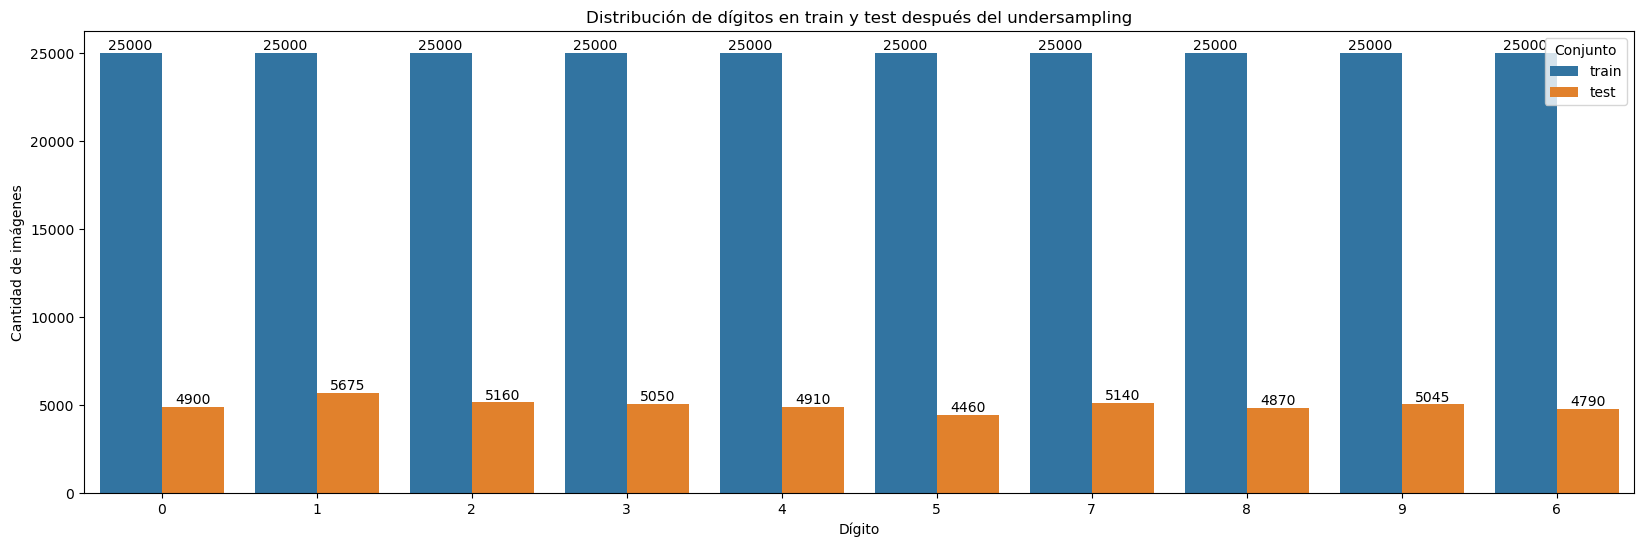

In [15]:
# Contar las imágenes por dígito y modalidad
df_counts = count_images_by_digit_and_mode('dataset')

# Graficar la distribución de dígitos en general en train y test
plt.figure(figsize=(20, 6))
ax = sns.countplot(data=df_counts, x='digit', hue='mode')

# Etiquetas en las barras con la cantidad de imágenes
for container in ax.containers:
    ax.bar_label(container)

# Configuración de la gráfica
plt.title('Distribución de dígitos en train y test después del undersampling')
plt.legend(title='Conjunto', loc='upper right')
plt.xlabel('Dígito')
plt.ylabel('Cantidad de imágenes')
plt.show()

Con esta ejecucion ahora todos los digitos en el conjunto de entrenamiento estan balanceados. Se ignora el conjunto de pruebas pues los proximos modelos no se basaran en esos datos para aprender a clasificar digitos.

### Escalado de imágenes

Se considera la posibilidad de reducir la resolución de las imágenes de dígitos del tamaño original de `28x28` a dimensiones más pequeñas de `25x25`, `20x20`, `15x15` y `10x10` píxeles. El objetivo de este experimento es evaluar cuánta información relevante se pierde en el proceso de escalado, especialmente para dígitos que son visualmente similares y pueden confundirse fácilmente. 

Antes de aplicar cualquier cambio a todo el conjunto de datos, se realizarán pruebas selectivas utilizando muestras aleatorias de imágenes para los dígitos **8**, **3**, **7** y **1** para la modalidad m0. 

De esta manera, sera posible observar el impacto del escalado en la legibilidad y distinción de características críticas antes de tomar una decisión sobre la resolución óptima para el entrenamiento.

In [16]:
def load_and_resize_image(image_path, new_size):
    """
    Cargar una imagen y redimensionarla.

    Args:
        image_path (str): Ruta de la imagen.
        new_size (tuple): Nueva dimensión de la imagen.
    
    Returns:
        PIL.Image: Imagen redimensionada.
    """
    # Cargar la imagen
    image = Image.open(image_path)

    # Redimensionar la imagen con interpolación bicúbica
    resized_image = image.resize(size=new_size, 
                        resample=Image.Resampling.LANCZOS)
    
    return resized_image

In [17]:
def find_random_images(base_path, digits, num_images=1):
    """
    Encontrar imágenes aleatorias de los dígitos especificados en la ruta base.

    Args:
        base_path (str): Ruta base de las imágenes.
        digits (list): Lista de dígitos a buscar.
        num_images (int): Número de imágenes a seleccionar por dígito.
    
    Returns:
        list: Lista de rutas de las imágenes seleccionadas.
    """
    image_paths = []
    # Recorrer los dígitos
    for digit in digits:
        # Encontrar las imágenes del dígito
        digit_paths = [os.path.join(base_path, f) for f in os.listdir(base_path) if f.endswith(f'.{digit}.png')]
        
        # Seleccionar imágenes aleatorias
        selected_images = random.sample(digit_paths, num_images)

        # Agregar las rutas de las imágenes seleccionadas
        image_paths.extend(selected_images)
        
    return image_paths

In [18]:
def compare_resolutions(image_paths, sizes):
    """
    Comparar las resoluciones de las imágenes redimensionadas.

    Args:
        image_paths (list): Lista de rutas de las imágenes.
        sizes (list): Lista de tamaños de redimensionamiento.

    Returns:
        None
    """
    fig, axes = plt.subplots(len(image_paths), len(sizes), figsize=(20, len(image_paths) * 3))
    
    for i, image_path in enumerate(image_paths):
        original_image = Image.open(image_path)
        for j, size in enumerate(sizes):
            resized_image = load_and_resize_image(image_path, size)
            digit = image_path.split('.')[-2]
            ax = axes[i, j] if len(image_paths) > 1 else axes[j]
            ax.imshow(np.array(resized_image))
            ax.set_title(f'Digito {digit} - Dimension: {size[0]}x{size[1]}')
            ax.axis('off')

    plt.suptitle('Comparación de resoluciones de imágenes', fontsize=20)
    plt.tight_layout()
    plt.show()

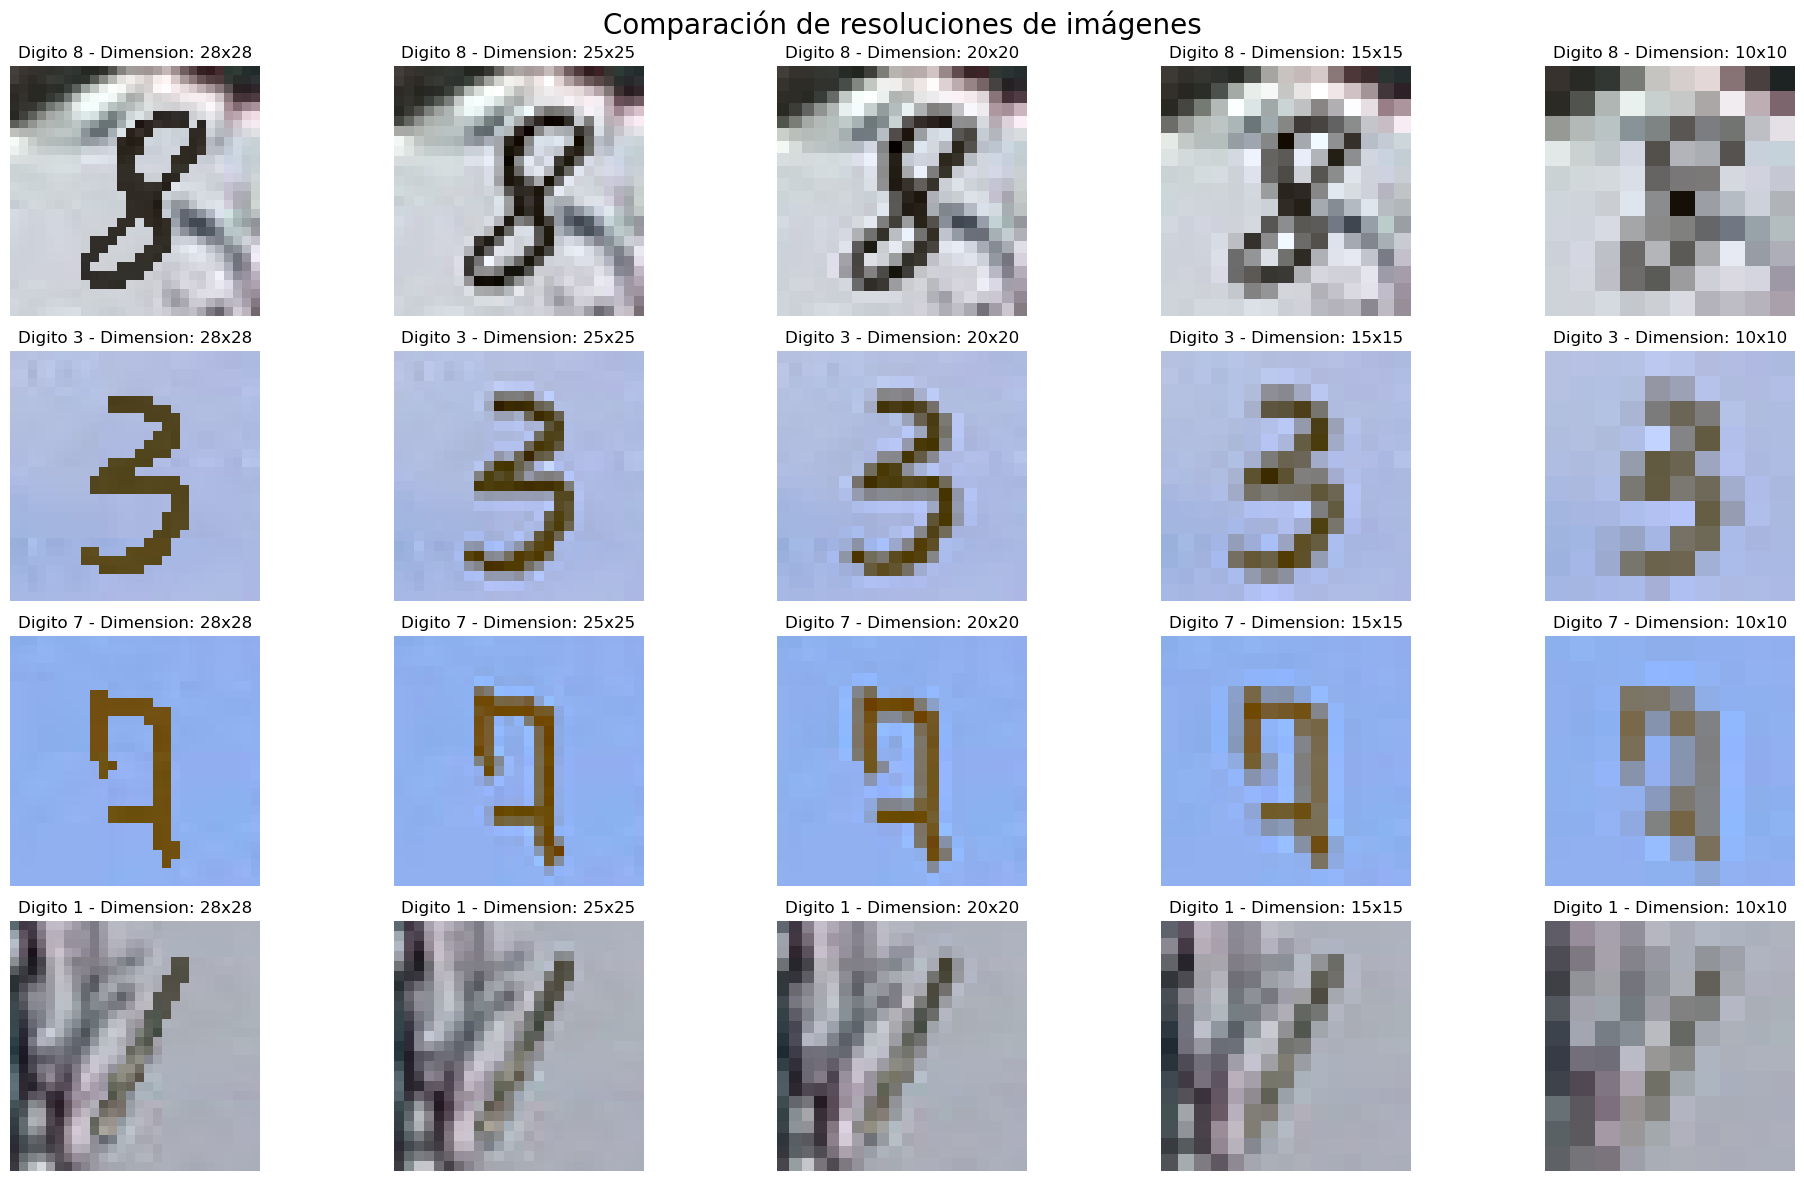

In [19]:
# Ruta al directorio de entrenamiento de la modalidad 1
train_dataset_path = 'dataset/train/m0'

# Dígitos específicos que queremos comparar
digits_of_interest = ['8', '3', '7', '1']

# Encuentra imágenes aleatorias para cada dígito especificado
image_paths = find_random_images(train_dataset_path, digits_of_interest, num_images=1)

sizes = [(28, 28), (25, 25), (20, 20), (15,15), (10, 10)]
# Compara las resoluciones de las imágenes
compare_resolutions(image_paths, sizes)

Los resultados de las pruebas de escalado mostraron que, aunque en hay casos donde la información se conserva de manera relativamente satisfactoria, existen situaciones específicas donde incluso en la resolución original era difícil distinguir claramente el dígito. Al reducir aún más la resolución, estos dígitos se volvieron prácticamente indistinguibles del fondo, perdiendo detalles cruciales como la presencia de un suaviazado de los bordes de los numeros, que son esenciales para un reconocimiento preciso. Dada la importancia de mantener una alta precisión y minimizar la confusión entre dígitos similares en los modelos, se decidio no escalar las imágenes y dejarlas con su resolución original de **28x28** pixeles

### Guardado del dataset como CSV

In [20]:
def image_to_row(image_path, label):
    """
    Convertir una imagen en una fila de datos.

    Args:
        image_path (str): Ruta de la imagen.
        label (int): Etiqueta de la imagen.

    Returns:
        list: Lista con la etiqueta y los valores de píxeles de la imagen.
    """
    image = Image.open(image_path).convert('L')  # Convertir a escala de grises
    image_array = np.array(image).flatten()  # Aplanar la matriz de la imagen a una fila
    return [label] + image_array.tolist()

In [21]:
def process_dataset(folder, output_csv):
    """
    Procesar un conjunto de imágenes en una carpeta y generar un DataFrame.

    Args:
        folder (str): Ruta de la carpeta con las imágenes.
        output_csv (str): Ruta del archivo CSV de salida.

    Returns:
        pd.DataFrame: DataFrame con los datos de las imágenes.
    """
    data = []
    
    # Calcular el número total de imágenes para la barra de progreso
    total_images = sum(len(files) for _, _, files in os.walk(folder))
    
    with tqdm(total=total_images, desc=f"Procesando {folder}", unit=" imagen") as pbar:
        for mode in ['m0', 'm1', 'm2', 'm3', 'm4']:
            mode_path = os.path.join(folder, mode)
            for filename in os.listdir(mode_path):
                if filename.endswith('.png'):
                    label = int(filename.split('.')[1])  # Obtener el dígito de la imagen
                    file_path = os.path.join(mode_path, filename)
                    data.append(image_to_row(file_path, label))
                    pbar.update(1)  # Actualizar la barra de progreso
    
    # Crear un DataFrame y guardar en CSV
    print("\nGenerando columnas de dataframe...")
    columns = ['label'] + [f'pixel{i}' for i in range(784)]
    
    print("\nGenerando DataFrame...")
    df = pd.DataFrame(data, columns=columns, dtype=np.float32)
    
    df.to_csv(output_csv, index=False)
    print(f"\nEXITO: DataFrame generado y guardado en '{output_csv}'.")
    return df

Se verifica si las carpetas de datos ya existen o no en el espacio de trabajo, de esta manera se evita tener que realizar el procesamiento cada vez que se ejecuta el notebook.

In [22]:
if not os.path.exists('data/train.csv'):
    train_df = process_dataset('dataset/train', 'data/train.csv')
else:
    print("Archivo 'train.csv' ya existe. Se omite el procesamiento.")
    print("Cargando el archivo 'train.csv'...")
    train_df = pd.read_csv('data/train.csv', dtype=np.float32)

Procesando dataset/train: 100%|██████████| 250000/250000 [00:58<00:00, 4247.19 imagen/s]



Generando columnas de dataframe...

Generando DataFrame...

EXITO: DataFrame generado y guardado en 'data/train.csv'.


In [23]:
if not os.path.exists('data/test.csv'):
    test_df = process_dataset('dataset/test', 'data/test.csv')
else:
    print("Archivo 'test.csv' ya existe. Se omite el procesamiento.")
    print("Cargando el archivo 'test.csv'...")
    test_df = pd.read_csv('data/test.csv', dtype=np.float32)

Procesando dataset/test: 100%|██████████| 50000/50000 [00:11<00:00, 4345.14 imagen/s]



Generando columnas de dataframe...

Generando DataFrame...

EXITO: DataFrame generado y guardado en 'data/test.csv'.


## Neural Networks Pipeline

Se define un conjunto de funciones que, en conjunto, forman un pipeline de trabajo para diseñar e implementar modelos de redes neuronales utilizando PyTorch y CUDA, si está disponible. El objetivo de este pipeline es facilitar la reproducibilidad y la experimentación, evitando la necesidad de repetir todo el código requerido por PyTorch para configurar y entrenar un modelo.

### Preparación de Datos

In [24]:
def preprocessing(train, test, split_train_size = 0.2):
    """
    Preprocesar los datos de entrenamiento y prueba para el modelo.
    Genera tensores de PyTorch para los conjuntos de entrenamiento, validación y prueba.
    Divide el conjunto de entrenamiento en entrenamiento y validación.

    Args:
        train (pd.DataFrame): DataFrame con los datos de entrenamiento.
        test (pd.DataFrame): DataFrame con los datos de prueba.
        split_train_size (float): Proporción del conjunto de entrenamiento para validación.

    Returns:
        X_train (torch.Tensor): Conjunto de datos de entrenamiento.
        y_train (torch.Tensor): Etiquetas de entrenamiento.
        X_val (torch.Tensor): Conjunto de datos de validación.
        y_val (torch.Tensor): Etiquetas de validación.
        X_test (torch.Tensor): Conjunto de datos de prueba.
        y_test (torch.Tensor): Etiquetas de prueba.
    """
    
    # Dividir el conjunto de entrenamiento en características y etiquetas
    targets = train.label.values
    features = train.drop(["label"], axis = 1).values
    
    # Normalizar las características
    features = features/255.0
    X_test = test.drop(["label"], axis=1).values / 255.0
    y_test = test.label.values
    
    # Generar un conjunto de validación a partir del conjunto de entrenamiento 
    # para evaluar el rendimiento del modelo 
    X_train, X_val, y_train, y_val = train_test_split(features,
                                                      targets,
                                                      test_size = split_train_size,
                                                      random_state = 42) 
    
    # Convertir los conjuntos de datos de entrenamiento a tensores de PyTorch
    X_train = torch.from_numpy(X_train)
    y_train = torch.from_numpy(y_train).type(torch.LongTensor)

    # Convertir los conjuntos de datos de validación a tensores de PyTorch
    X_val = torch.from_numpy(X_val)
    y_val = torch.from_numpy(y_val).type(torch.LongTensor)
    
    # Convertir el conjunto de datos de prueba a tensores de PyTorch
    X_test = torch.from_numpy(X_test)
    y_test = torch.from_numpy(y_test).type(torch.LongTensor)

    print(f'Dimensiones de los datos de entrenamiento: {X_train.shape}')
    print(f'\nDimensiones de las etiquetas de entrenamiento: {y_train.shape}')
    print(f'\nDimensiones de los datos de validación: {X_val.shape}')
    print(f'\nDimensiones de las etiquetas de validación: {y_val.shape}')
    print(f'\nDimensiones de los datos de prueba: {X_test.shape}')
    print(f'\nDimensiones de las etiquetas de prueba: {y_test.shape}')
    
    return X_train, y_train, X_val, y_val, X_test, y_test

### Preparación de Data Loaders

In [25]:
def get_data_loaders(X_train, y_train, X_val, y_val, X_test, y_test, batch_size):
    """
    Crear dataloaders para los conjuntos de entrenamiento, validación y prueba.

    Args:
        X_train (torch.Tensor): Características del conjunto de entrenamiento.
        y_train (torch.Tensor): Etiquetas del conjunto de entrenamiento.
        X_val (torch.Tensor): Características del conjunto de validación.
        y_val (torch.Tensor): Etiquetas del conjunto de validación.
        X_test (torch.Tensor): Características del conjunto de prueba.
        y_test (torch.Tensor): Etiquetas del conjunto de prueba.
        batch_size (int): Tamaño del lote para el dataloader.

    Returns:
        train_loader (torch.utils.data.DataLoader): Dataloader para el conjunto de entrenamiento.
        val_loader (torch.utils.data.DataLoader): Dataloader para el conjunto de validación.
        test_loader (torch.utils.data.DataLoader): Dataloader para el conjunto de prueba.
    """
    # Crear conjuntos de datos con tensores de PyTorch
    train_tensor = torch.utils.data.TensorDataset(X_train, y_train)
    val_tensor = torch.utils.data.TensorDataset(X_val, y_val)
    test_tensor = torch.utils.data.TensorDataset(X_test, y_test)

    # Crear dataloaders para el conjunto de entrenamiento, validación y prueba
    train_loader = torch.utils.data.DataLoader(train_tensor, 
                                            batch_size = batch_size,
                                            shuffle = True)

    val_loader = torch.utils.data.DataLoader(val_tensor, 
                                            batch_size = batch_size, 
                                            shuffle = False)

    test_loader = torch.utils.data.DataLoader(test_tensor, 
                                            batch_size = batch_size,
                                            shuffle = False)
    
    return train_loader, val_loader, test_loader

### Creacion de la Neural Network

In [26]:
def instantiate_model(model_class):
    """
    Instanciar un modelo de red neuronal.
    Configurar el optimizador, la función de pérdida y el scheduler.
    Habilitar CUDA si está disponible.

    Args:
        model_class (class): Clase del modelo de red neuronal.

    Returns:
        model (torch.nn.Module): Modelo de red neuronal.
        optimizer (torch.optim.Optimizer): Optimizador del modelo.
        criterion (torch.nn.Module): Función de pérdida del modelo.
        exp_lr_scheduler (torch.optim.lr_scheduler._LRScheduler): Scheduler para la tasa de aprendizaje.
    """
    # Instanciar el modelo CNN 
    model = model_class()

    # Optimizador Adam
    optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

    # Función de pérdida de entropía cruzada 
    criterion = nn.CrossEntropyLoss()

    # Scheduler para reducir la tasa de aprendizaje
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

    # Verificando si CUDA (GPU) está disponible
    if torch.cuda.is_available():
        print(f"CUDA DISPONIBLE: si")
        gpu_name = torch.cuda.get_device_name(torch.cuda.current_device())
        print(f"El modelo se entrenara con GPU: \n\t{gpu_name}")
        model = model.cuda()
        criterion = criterion.cuda()
    else:
        print(f"CUDA DISPONIBLE: no")
        print("El modelo se entrenara con CPU")

    return model, optimizer, criterion, exp_lr_scheduler

### Entrenamiento

In [27]:
def fit(model, train_loader, criterion, optimizer, exp_lr_scheduler, batch_size):
    """
    Entrenar el modelo de red neuronal. 
    Generar la pérdida y la precisión de entrenamiento.

    Args:
        model (torch.nn.Module): Modelo de red neuronal.
        train_loader (torch.utils.data.DataLoader): Dataloader para el conjunto de entrenamiento.
        criterion (torch.nn.Module): Función de pérdida del modelo.
        optimizer (torch.optim.Optimizer): Optimizador del modelo.
        exp_lr_scheduler (torch.optim.lr_scheduler._LRScheduler): Scheduler para la tasa de aprendizaje.
        batch_size (int): Tamaño del lote para el dataloader.

    Returns:
        train_loss (float): Pérdida de entrenamiento.
        train_accuracy (float): Precisión de entrenamiento.
    """

    # Establecer el modelo en modo de entrenamiento    
    model.train()
    
    # Inicializar la pérdida y la precisión de entrenamiento
    train_running_loss = 0.0
    train_running_correct = 0

    # Iterar sobre el conjunto de entrenamiento
    for data, target in train_loader:
        data, target = Variable(data.view(batch_size,1,28,28)), Variable(target)
        
        # Verificar si CUDA está disponible
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        
        # Reestablecer los gradientes a cero
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        
        # Actualizar los gradientes
        train_running_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        train_running_correct += (preds == target).sum().item()
        
        # Backward Propagation y optimización
        loss.backward()
        optimizer.step()
            
    # Actualizar el parámetro lr
    exp_lr_scheduler.step()
            
    # Calcular la pérdida y la precisión de entrenamiento
    train_loss = train_running_loss/len(train_loader.dataset)
    train_accuracy = 100. * train_running_correct/len(train_loader.dataset)    
    
    return train_loss, train_accuracy

### Validacion

In [28]:
def validate(model, data_loader, batch_size, criterion):
    """
    Validar el modelo de red neuronal.
    Generar la pérdida y la precisión de validación.
    Generar las predicciones y probabilidades de validación.

    Args:
        model (torch.nn.Module): Modelo de red neuronal.
        data_loader (torch.utils.data.DataLoader): Dataloader para el conjunto de validación.
        batch_size (int): Tamaño del lote para el dataloader.
        criterion (torch.nn.Module): Función de pérdida del modelo.

    Returns:
        loss (float): Pérdida de validación.
        accuracy (float): Precisión de validación.
        predictions (torch.Tensor): Predicciones de validación.
        probabilities (torch.Tensor): Probabilidades de validación.
    """
    
    # Establecer el modelo en modo de validación
    model.eval()
    predictions = torch.LongTensor().cuda()
    probabilities = torch.LongTensor().cuda()
    
    # Inicializar la pérdida y la precisión de validación
    running_loss = 0.0
    running_correct = 0
    
    # Iterar sobre el conjunto de validación
    with torch.no_grad():
        for data, target in data_loader:

            # Arreglar las dimensiones de los datos
            data = data.view(batch_size, 1, 28, 28)
            
            # Verificar si CUDA está disponible
            if torch.cuda.is_available():
                data = data.cuda()
                target = target.cuda()
            
            # Calcular la salida y la pérdida
            output = model(data)
            loss = criterion(output, target)
            
            # Actualizar la pérdida de validación 
            # y las predicciones correctas
            running_loss += loss.item()
            pred = output.data.max(1, keepdim=True)[1]
            proba = torch.nn.functional.softmax(output.data, dim=1)

            # Actualizar la precisión de validación
            running_correct += pred.eq(target.data.view_as(pred)).cpu().sum() 
            
            # Almacenar las predicciones de validación con probabilidades para cálculos de matriz de confusión 
            # y los mejores errores cometidos
            predictions = torch.cat((predictions, pred), dim=0)
            probabilities = torch.cat((probabilities, proba))

    # Calcular la pérdida y la precisión de validación
    loss = running_loss/len(data_loader.dataset)
    accuracy = 100. * running_correct/len(data_loader.dataset) 
    
    return loss, accuracy, predictions, probabilities

### Medicion de tiempo

In [29]:
def epoch_time(start_time, end_time):
    """
    Calcular el tiempo transcurrido en minutos y segundos.

    Args:
        start_time (float): Tiempo de inicio.
        end_time (float): Tiempo de finalización.

    Returns:
        elapsed_mins (int): Minutos transcurridos.
        elapsed_secs (int): Segundos transcurridos.
    """
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

### Entrenamiento, Validacion y predicciones del Modelo

In [30]:
def train_validate_model(epochs, model, train_loader, val_loader, test_loader, criterion, optimizer, exp_lr_scheduler, batch_size):
    """
    Entrenar y validar un modelo de red neuronal.
    Generar las pérdidas y precisiones de entrenamiento y validación.
    Generar las predicciones y probabilidades de validación y prueba.

    Args:
        epochs (int): Número de épocas.
        model (torch.nn.Module): Modelo de red neuronal.
        train_loader (torch.utils.data.DataLoader): Dataloader para el conjunto de entrenamiento.
        val_loader (torch.utils.data.DataLoader): Dataloader para el conjunto de validación.
        test_loader (torch.utils.data.DataLoader): Dataloader para el conjunto de prueba.
        criterion (torch.nn.Module): Función de pérdida del modelo.
        optimizer (torch.optim.Optimizer): Optimizador del modelo.
        exp_lr_scheduler (torch.optim.lr_scheduler._LRScheduler): Scheduler para la tasa de aprendizaje.
        batch_size (int): Tamaño del lote para el dataloader.

    Returns:
        train_loss (list): Pérdidas de entrenamiento por época.
        train_accuracy (list): Precisión de entrenamiento por época.
        val_loss (list): Pérdidas de validación por época.
        val_accuracy (list): Precisión de validación por época.
        val_preds (list): Predicciones de validación por época.
        val_proba (list): Probabilidades de validación por época.
        test_loss (list): Pérdidas de prueba por época.
        test_accuracy (list): Precisión de prueba por época.
        test_preds (list): Predicciones de prueba por época.
        test_proba (list): Probabilidades de prueba por época.
    """
    # Listas para almacenar la pérdida y la precisión de entrenamiento y validación
    train_loss, train_accuracy = [], []
    val_loss, val_accuracy = [], []
    test_loss, test_accuracy = [], []
    val_preds, val_proba = [], []
    test_preds, test_proba = [], []

    # Iterar sobre las épocas
    for epoch in range(epochs):
        # Inicializar el tiempo de inicio
        start_time = time.time()
        
        # Entrenar y validar el modelo
        train_epoch_loss, train_epoch_accuracy = fit(model, 
                                                     train_loader, 
                                                     criterion, 
                                                     optimizer, 
                                                     exp_lr_scheduler, 
                                                     batch_size)
        
        val_epoch_loss, val_epoch_accuracy, val_epoch_preds, val_epoch_proba = validate(model, 
                                                                                        val_loader, 
                                                                                        batch_size, 
                                                                                        criterion)
        
        test_epoch_loss, test_epoch_accuracy, test_epoch_preds, test_epoch_proba = validate(model, 
                                                                                            test_loader, 
                                                                                            batch_size, 
                                                                                            criterion)

        # Obtener las perdidas y la precisiones de validación
        train_loss.append(train_epoch_loss)
        train_accuracy.append(train_epoch_accuracy)
        
        # Almacenar las perdidas y la precisiones de validación
        val_loss.append(val_epoch_loss)
        val_accuracy.append(val_epoch_accuracy)

        # Almacenar las perdidas y la precisiones de prueba
        test_loss.append(test_epoch_loss)
        test_accuracy.append(test_epoch_accuracy)

        # Almacenar las predicciones y probabilidades de validación
        val_preds.append(val_epoch_preds)
        val_proba.append(val_epoch_proba)

        # Almacenar las predicciones y probabilidades de prueba
        test_preds.append(test_epoch_preds)
        test_proba.append(test_epoch_proba)
        
        
        # Detener el tiempo de finalización
        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        # Imprimir la pérdida y la precisión de entrenamiento y validación
        print(f'Epoch: {epoch+1:02} | Time: {int(epoch_mins)}m {int(epoch_secs)}s')
        print(f'\tTrain Loss: {train_epoch_loss:.3f} | Train Accuracy: {train_epoch_accuracy:.2f}')
        print(f'\t Val. Loss: {val_epoch_loss:.3f} |  Val. Accuracy: {val_epoch_accuracy:.2f}')
        print(f'\t Test Loss: {test_epoch_loss:.3f} |  Test Accuracy: {test_epoch_accuracy:.2f}')
    
    return train_loss, train_accuracy, val_loss, val_accuracy, val_preds, val_proba, test_loss, test_accuracy, test_preds, test_proba


### Gráficos de Resultados

#### Historial de Rendimiento

In [31]:
def plot_history(train_loss, val_loss, test_loss, train_acc, val_acc, test_acc, name):
    """
    Graficar la pérdida y la precisión de entrenamiento, validación y prueba.

    Args:
        train_loss (list): Pérdidas de entrenamiento por época.
        val_loss (list): Pérdidas de validación por época.
        test_loss (list): Pérdidas de prueba por época.
        train_acc (list): Precisión de entrenamiento por época.
        val_acc (list): Precisión de validación por época.
        test_acc (list): Precisión de prueba por época.
        name (str): Nombre del modelo.

    Returns:
        None
    """
    # Crear un solo plot con dos subplots: uno para accuracy y otro para loss
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Subplot para la precisión
    axes[0].plot(train_acc, label='Precisión de Entrenamiento')
    axes[0].plot(val_acc, label='Precisión de Validación')
    axes[0].plot(test_acc, label='Precisión de Prueba', linestyle='--')
    axes[0].set_title('Precision del Modelo')
    axes[0].set_xlabel('Epoca')
    axes[0].set_ylabel('Precision')
    axes[0].legend(loc='upper left')
    axes[0].grid(True)
    
    # Subplot para la pérdida
    axes[1].plot(train_loss, label='Pérdida de Entrenamiento')
    axes[1].plot(val_loss, label='Pérdida de Validación')
    axes[1].plot(test_loss, label='Pérdida de Prueba', linestyle='--')
    axes[1].set_title('Pérdida del Modelo')
    axes[1].set_xlabel('Epoca')
    axes[1].set_ylabel('Pérdida')
    axes[1].legend(loc='upper right')
    axes[1].grid(True)
    
    # Configuración general de la figura
    plt.suptitle(f"Historial de Entrenamiento del Modelo - {name}", fontsize=20)
    plt.tight_layout()
    plt.show()

#### Predicciones y Evaluacion del Modelo

In [32]:
def plot_confusion_matrix(y_test, test_preds, epochs, name):
    """
    Graficar la matriz de confusión del modelo a partir de las predicciones de prueba.
    Configurar las etiquetas con conteos y porcentajes por clase.

    Args:
        y_test (torch.Tensor): Etiquetas de prueba.
        test_preds (list): Predicciones de prueba.
        epochs (int): Número de épocas.
        name (str): Nombre del modelo.

    Returns:
        None
    """
    # Obtener las predicciones de validación
    y_pred_classes = test_preds[epochs - 1].cpu().numpy().ravel()

    # Calcular la matriz de confusión
    cm = confusion_matrix(y_test, y_pred_classes)

    # Normalizar la matriz de confusión por filas (por clases reales)
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Configurar las etiquetas con conteos y porcentajes por clase
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm_percentage.flatten()]
    box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cm.shape[0], cm.shape[1])
    
    # Graficar la matriz de confusión
    plt.figure(figsize=(12, 10))
    sns.heatmap(data=cm, 
                annot=box_labels, 
                fmt="", 
                linewidths=1, 
                linecolor='black',
                cmap="coolwarm", 
                xticklabels=range(10), 
                yticklabels=range(10))
    
    plt.yticks(rotation=0)
    plt.xlabel('Digitos Predichos')
    plt.ylabel('Digitos Reales')
    plt.title(f"Matriz de Confusión del Modelo - {name}")
    plt.show()

#### Muestreo de Predicciones

In [33]:
def plot_predictions_sample(test_preds, y_test, X_test, epochs, name):
    """
    Graficar un muestreo de predicciones correctas e incorrectas del modelo.
    Las predicciones correctas se muestran en un subplot y las incorrectas en otro.

    Args:
        test_preds (list): Predicciones de prueba.
        y_test (torch.Tensor): Etiquetas de prueba.
        X_test (torch.Tensor): Características del conjunto de prueba.
        epochs (int): Número de épocas.
        name (str): Nombre del modelo.

    Returns:
        None
    """
    # Definir el tamaño de las predicciones correctas e incorrectas
    correct_size = 9
    wrong_size = 9

    # Obtener las predicciones de validación
    y_pred_classes = test_preds[epochs - 1].cpu().numpy().ravel()

    # Mostrar los errores de clasificación
    errors = (y_pred_classes - y_test.cpu().numpy() != 0)

    # Obtener las clases de los errores
    y_pred_classes_errors = y_pred_classes[errors]
    y_true_errors = y_test[errors]
    X_val_errors = X_test[errors]

    # Crear la figura con 2 subplots (3x3 cada uno) y espacio para la línea divisoria
    fig, axes = plt.subplots(3, 7, figsize=(20, 10), gridspec_kw={'width_ratios': [1, 1, 1, 0.1, 1, 1, 1]})
    fig.suptitle(f"Muestreo de Predicciones del Modelo - {name}", fontsize=20)
    
    # Subplot para predicciones correctas (3x3)
    correct_indices = [i for i in range(len(y_test)) if y_test[i] == y_pred_classes[i]]
    random_correct_indices = random.sample(correct_indices, correct_size)
    
    for i, index in enumerate(random_correct_indices):
        ax = axes[i // 3, i % 3]  # Ubicar en las primeras 3 columnas (3x3 subplots)
        ax.imshow(X_test[index].view(28, 28), cmap='gray')
        ax.set_title(f"Predicho: {y_pred_classes[index]}\nReal: {y_test[index]}")
        ax.axis('off')
    
    # Dibujar la línea divisoria en un subplot central reducido
    for j in range(3):
        axes[j, 3].axis('off')  # Desactivar los ejes para las celdas de la línea divisoria
        axes[j, 3].plot([0.5, 0.5], [0, 1], transform=axes[j, 3].transAxes, color='black', linewidth=2)
    
    # Subplot para predicciones erróneas (3x3)
    random_error_indices = random.sample(range(len(y_true_errors)), wrong_size)
    
    for i, index in enumerate(random_error_indices):
        ax = axes[i // 3, 4 + i % 3]  # Ubicar en las últimas 3 columnas (3x3 subplots)
        ax.imshow(X_val_errors[index].view(28, 28), cmap='gray')
        ax.set_title(f"Predicho: {y_pred_classes_errors[index]}\nReal: {y_true_errors[index]}")
        ax.axis('off')
    
    # Título para cada conjunto de subplots
    fig.text(0.20, 0.92, "Predicciones Correctas", ha="center", fontsize=16)
    fig.text(0.80, 0.92, "Predicciones Erróneas", ha="center", fontsize=16)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.90])
    plt.show()

## Redes Neuronales Convolucionales

### PyTorch Datasets

Se generan los tensores de dataset con los conjuntos de datos de entrenamiento y pruebas.

In [34]:
X_train, y_train, X_val, y_val, X_test, y_test = preprocessing(train_df, test_df)

Dimensiones de los datos de entrenamiento: torch.Size([200000, 784])

Dimensiones de las etiquetas de entrenamiento: torch.Size([200000])

Dimensiones de los datos de validación: torch.Size([50000, 784])

Dimensiones de las etiquetas de validación: torch.Size([50000])

Dimensiones de los datos de prueba: torch.Size([50000, 784])

Dimensiones de las etiquetas de prueba: torch.Size([50000])


### Modelo 1

#### Hiperparametros

Se definen los hiperparámetros del modelo de red neuronal convolucional, optimizados para lograr un equilibrio entre rendimiento y tiempo de procesamiento. Aumentar estos valores podría resultar en overfitting o en mejoras marginales en el rendimiento, pero a costa de un procesamiento computacional significativamente más intensivo, lo que no justifica un incremento de tiempo de ejecución por mejoras inferiores al 1-2%.

In [35]:
# Definir hiperparámetros
batch_size1 = 100        # Tamaño del lote
n_iter1 = 2500           # Número de iteraciones
epochs1 = 5              # Número de épocas

#### PyTorch Dataloaders

Se generan los dataloaders para los conjuntos de entrenamiento, validación y prueba a partir de los datos originales, utilizando el hiperparámetro de tamaño de lote.

In [36]:
train_loader1, val_loader1, test_loader1 = get_data_loaders(X_train=X_train, 
                                                         y_train=y_train, 
                                                         X_val=X_val, 
                                                         y_val=y_val, 
                                                         X_test=X_test,
                                                         y_test=y_test, 
                                                         batch_size=batch_size1)

#### Definicion de Arquitectura

Se define una arquitectura que:
- Tiene dos capas de convolución seguidas de capas de pooling y dropout, lo que permite aprender características fundamentales de las imágenes.
- Tiene capas de convolución utilizan 16 y 32 filtros respectivamente, lo que es suficiente para extraer patrones importantes sin aumentar demasiado la complejidad.
- Utiliza dropout en todas las capas principales para reducir el riesgo de sobreajuste, manteniendo el modelo eficiente y generalizable.
- Tiene dos capas lineales al final realizan la combinación y clasificación de las características aprendidas, facilitando la predicción de las clases finales.

In [37]:
class CNN_Model1(nn.Module):
    def __init__(self):
        super(CNN_Model1, self).__init__()
        
        # Capa de convolución 1
        self.c1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(5,5), stride=1, padding=0)
        self.relu1 = nn.ReLU()
        
        # Capa de Max pooling 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2,2))
        
        # Capa de dropout 1
        self.dropout1 = nn.Dropout(0.25)
        
        # Capa de convolución 2
        self.c2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), stride=1, padding=0)
        self.relu2 = nn.ReLU()
        
        # Capa de Max pooling 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2,2))

        # Capa de dropout 2
        self.dropout2 = nn.Dropout(0.25)
        
        # Capa lineal 1
        self.fc1 = nn.Linear(32*5*5, 256)
        
        # Capa de dropout 3
        self.dropout3 = nn.Dropout(0.25)
        
        # Capa lineal 2
        self.fc2 = nn.Linear(256, 10)
        
    def forward(self, x):
        # Feedforward de la red
        
        # Capa de convolución 1
        out = self.c1(x)                    # [BATCH_SIZE, 16, 24, 24]
        out = self.relu1(out) 
        out = self.maxpool1(out)            # [BATCH_SIZE, 16, 12, 12]
        out = self.dropout1(out) 
        
        # Capa de convolución 2
        out = self.c2(out)                  # [BATCH_SIZE, 32, 10, 10]
        out = self.relu2(out) 
        out = self.maxpool2(out)            # [BATCH_SIZE, 32, 5, 5]
        out = self.dropout2(out) 
        
        # Aplanar la salida para la capa lineal
        out = out.view(out.size(0), -1)     # [BATCH_SIZE, 32*5*5=800]
        out = self.fc1(out)                 # [BATCH_SIZE, 256]
        out = self.dropout3(out)
        out = self.fc2(out)                 # [BATCH_SIZE, 10]
        
        return out

#### Instanciar Modelo

In [38]:
model1, optimizer1, criterion1, exp_lr_scheduler1 = instantiate_model(CNN_Model1)

CUDA DISPONIBLE: si
El modelo se entrenara con GPU: 
	NVIDIA GeForce RTX 3070 Ti Laptop GPU


#### Entrenar y Validar el Modelo

In [39]:
train_loss1, train_accuracy1, val_loss1, val_accuracy1, val_preds1, val_proba1, test_loss1, test_accuracy1, test_preds1, test_proba1 = (
    train_validate_model(epochs=epochs1, 
                         model=model1,
                         train_loader=train_loader1,
                         val_loader=val_loader1,
                         test_loader=test_loader1,
                         criterion=criterion1,
                         optimizer=optimizer1,
                         exp_lr_scheduler=exp_lr_scheduler1,
                         batch_size=batch_size1)
)

Epoch: 01 | Time: 0m 5s
	Train Loss: 0.006 | Train Accuracy: 82.39
	 Val. Loss: 0.004 |  Val. Accuracy: 89.82
	 Test Loss: 0.004 |  Test Accuracy: 90.33
Epoch: 02 | Time: 0m 6s
	Train Loss: 0.004 | Train Accuracy: 86.90
	 Val. Loss: 0.003 |  Val. Accuracy: 91.34
	 Test Loss: 0.003 |  Test Accuracy: 91.93
Epoch: 03 | Time: 0m 6s
	Train Loss: 0.004 | Train Accuracy: 87.72
	 Val. Loss: 0.003 |  Val. Accuracy: 91.86
	 Test Loss: 0.003 |  Test Accuracy: 92.36
Epoch: 04 | Time: 0m 6s
	Train Loss: 0.003 | Train Accuracy: 89.83
	 Val. Loss: 0.002 |  Val. Accuracy: 92.93
	 Test Loss: 0.002 |  Test Accuracy: 93.08
Epoch: 05 | Time: 0m 5s
	Train Loss: 0.003 | Train Accuracy: 90.20
	 Val. Loss: 0.002 |  Val. Accuracy: 93.46
	 Test Loss: 0.002 |  Test Accuracy: 93.85


El rendimiento del modelo muestra una mejora constante a lo largo de las épocas, con un incremento en la precisión desde el **82.39%** en la primera época hasta el **90.20%** en la quinta. De manera similar, la precisión en el conjunto de prueba mejora del **90.33%** al **93.85%**. Esta progresión indica que el modelo está aprendiendo de manera efectiva y generalizando bien, ya que la pérdida disminuye de manera constante en todos los conjuntos.

A pesar de las mejoras, el avance entre las últimas épocas es más reducido, lo que sugiere que el modelo está llegando a su capacidad máxima de aprendizaje con la configuración actual. Dado que el tiempo de ejecución es eficiente, con cada época completándose en 5-6 segundos, el modelo demuestra un buen equilibrio entre rendimiento y eficiencia.

#### Gráficos de Resultados

##### Historial de Rendimiento del modelo

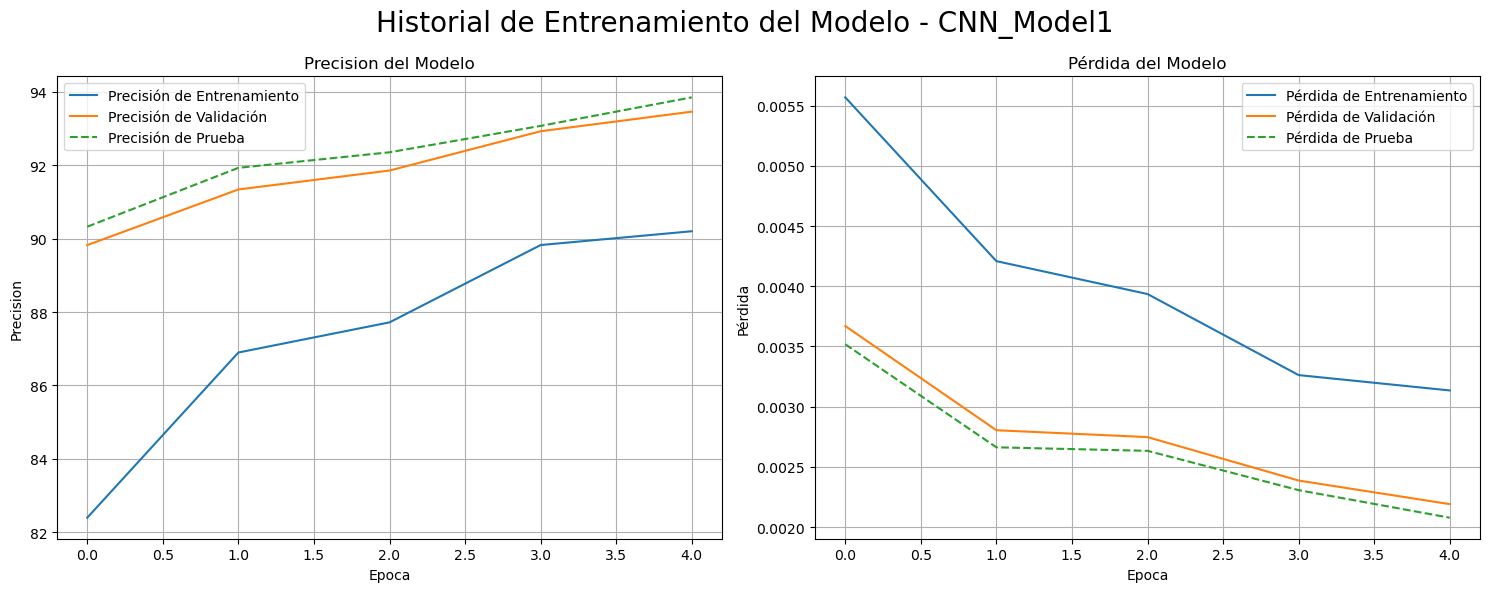

In [40]:
plot_history(train_loss1, val_loss1, test_loss1, train_accuracy1, val_accuracy1, test_accuracy1, 'CNN_Model1')

El gráfico confirma que el modelo alcanza su mejor rendimiento alrededor de la cuarta época, donde se observa un equilibrio óptimo entre precisión y tiempo de entrenamiento. La precisión en los conjuntos de validación y prueba mejora consistentemente, pero las ganancias se vuelven marginales en las últimas épocas, lo que sugiere que el modelo ha capturado la mayoría de los patrones importantes presentes en los datos.

La disminución de la pérdida también se ralentiza después de la tercera época, indicando que el modelo sigue ajustándose, pero con mejoras cada vez más pequeñas. En conjunto, esto sugiere que continuar el entrenamiento más allá de la cuarta época probablemente no ofrezca beneficios significativos, confirmando que el modelo ha llegado a su punto de rendimiento máximo.

##### Predicciones y Matriz de Confusion del Modelo

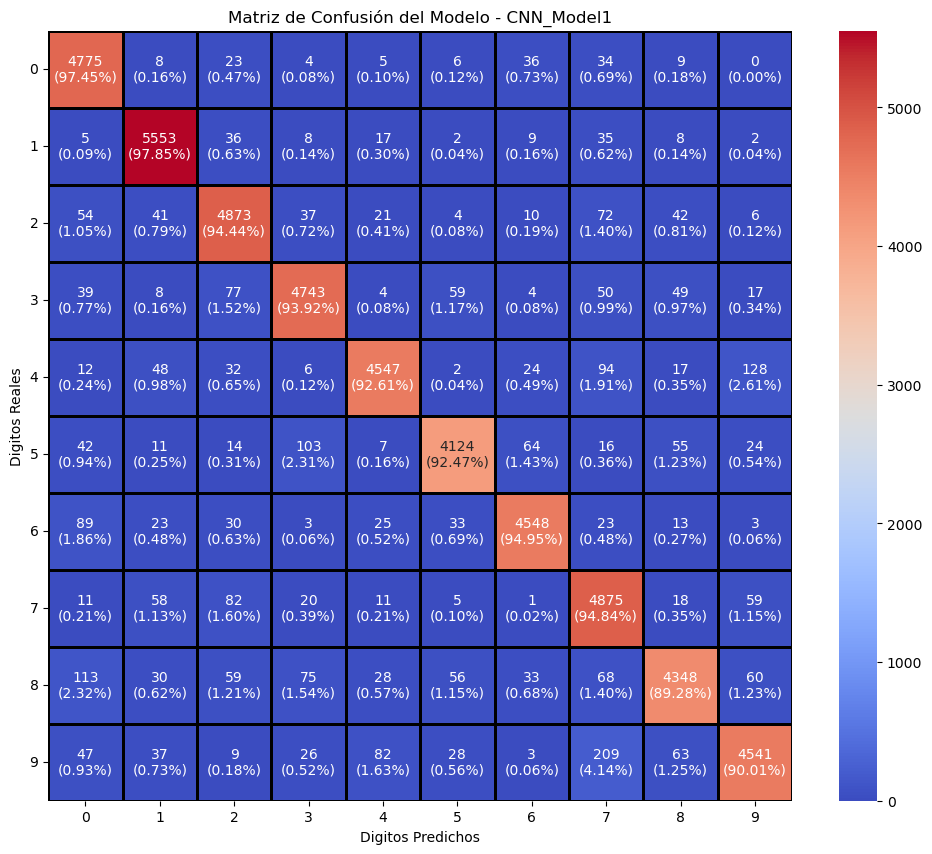

In [41]:
plot_confusion_matrix(y_test, test_preds1, epochs1, 'CNN_Model1')

La matriz de confusión muestra que el modelo CNN_Model1 tiene un buen rendimiento general, con la mayoría de los dígitos correctamente clasificados, como lo indica el alto porcentaje de precisión en la diagonal principal. La mayoría de las clases tienen una precisión superior al 90%, siendo la unica excepcion el dígito 8 que tiene una mayor tendencia a ser confundido por otros números.

##### Muestreo de Predicciones del Modelo

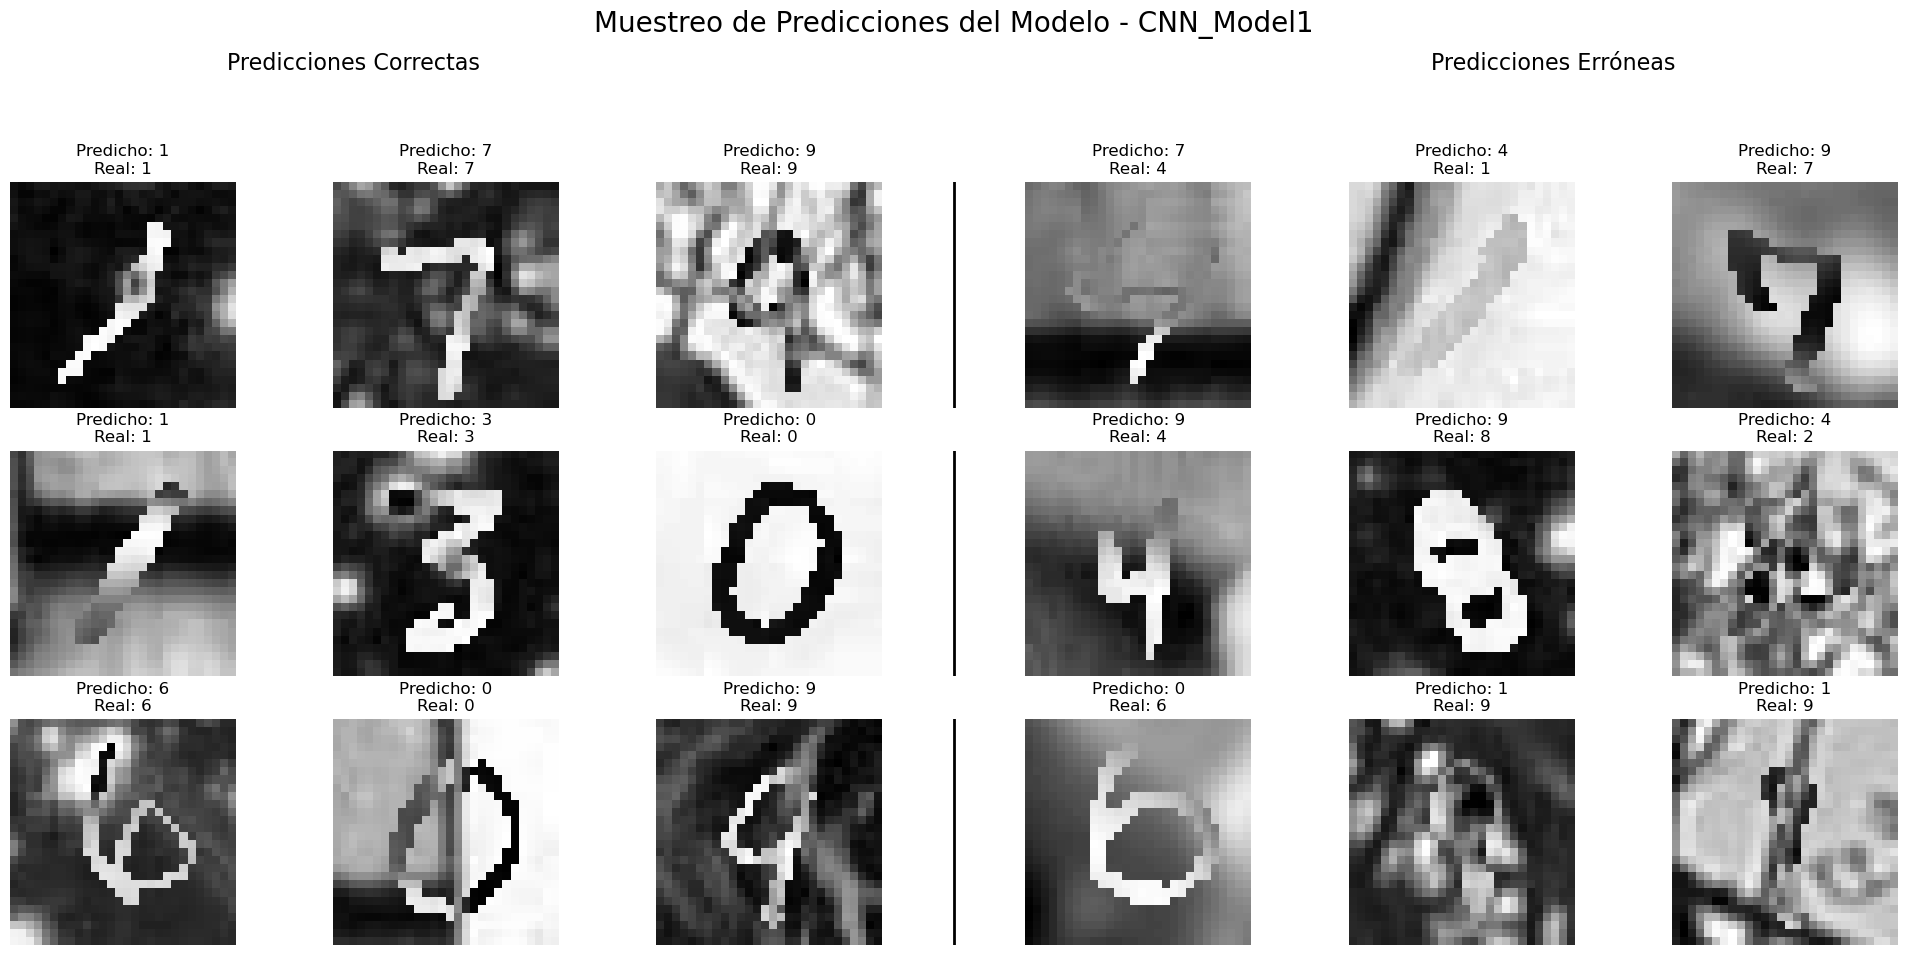

In [42]:
plot_predictions_sample(test_preds1, y_test, X_test, epochs1, 'CNN_Model1')

El muestreo de predicciones confirma lo que se observó en la matriz de confusión: las confusiones del modelo suelen ocurrir en dígitos con características visuales similares o en imágenes con ruido significativo. Esto es evidente en los ejemplos donde el modelo confunde dígitos como el 6 y el 8, o el 3 y el 8.

En general, las predicciones correctas se dan en imágenes más claras y definidas, mientras que las predicciones erróneas se explican por la similitud visual o la baja calidad de algunas imágenes, lo que hace comprensible la confusión del modelo.

### Guardar el Modelo

In [43]:
# Guardar el modelo entrenado
torch.save(model1.state_dict(), 'models/cnn_model1_no_augmentation.pth')

### Modelo 2

#### Hiperparametros

Para corroborar los hallazgos del Modelo 1, se entrenará otro modelo con un mayor número de iteraciones y épocas, además de una arquitectura diferente.

In [80]:
# Definir hiperparámetros
batch_size2 = 100        # Tamaño del lote
n_iter2 = 3000           # Número de iteraciones
epochs2 = 10              # Número de épocas

#### PyTorch Dataloaders

In [81]:
train_loader2, val_loader2, test_loader2 = get_data_loaders(X_train=X_train, 
                                                         y_train=y_train, 
                                                         X_val=X_val, 
                                                         y_val=y_val, 
                                                         X_test=X_test,
                                                         y_test=y_test, 
                                                         batch_size=batch_size2)

#### Definicion de Arquitectura

Se define una arquitectura que:
- Tiene tres capas de convolución, lo que le permite aprender características más complejas. 
- Tiene capas de convolución aumentan gradualmente la dimensionalidad (de 32 a 128 filtros), permitiendo la extracción de características más detalladas.
- Tiene un dropout que se incrementa en las capas lineales para reducir el overfitting, ya que el modelo es más complejo.
- Tiene dos capas lineales antes de la salida final, lo que ayuda a la red a aprender combinaciones más complejas de características antes de hacer la clasificación final.

A diferencia del `CNN_Model1`, este modelo incluye una tercera capa de convolución, aumenta progresivamente la cantidad de filtros (de 32 a 128) y utiliza un dropout más agresivo en las capas lineales, lo que le permite aprender características más complejas y detalladas, reduciendo el riesgo de overfitting en un modelo más profundo. Además, tiene dos capas lineales antes de la salida final para mejorar la capacidad de combinación y clasificación de las características aprendidas.

In [82]:
class CNN_Model2(nn.Module):
    def __init__(self):
        super(CNN_Model2, self).__init__()
        
        # Capa de convolución 1
        self.c1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3), stride=1, padding=1)
        self.relu1 = nn.ReLU()
        
        # Capa de Max pooling 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2,2))
        
        # Capa de dropout 1
        self.dropout1 = nn.Dropout(0.25)
        
        # Capa de convolución 2
        self.c2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), stride=1, padding=1)
        self.relu2 = nn.ReLU()
        
        # Capa de Max pooling 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2,2))
        
        # Capa de dropout 2
        self.dropout2 = nn.Dropout(0.25)
        
        # Capa de convolución 3
        self.c3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), stride=1, padding=1)
        self.relu3 = nn.ReLU()
        
        # Capa de Max pooling 3
        self.maxpool3 = nn.MaxPool2d(kernel_size=(2,2))
        
        # Capa de dropout 3
        self.dropout3 = nn.Dropout(0.25)
        
        # Capa lineal 1
        self.fc1 = nn.Linear(128*3*3, 512)
        self.relu4 = nn.ReLU()
        self.dropout4 = nn.Dropout(0.5)
        
        # Capa lineal 2
        self.fc2 = nn.Linear(512, 256)
        self.relu5 = nn.ReLU()
        self.dropout5 = nn.Dropout(0.5)
        
        # Capa lineal 3 (salida)
        self.fc3 = nn.Linear(256, 10)
        
    def forward(self, x):
        # Capa de convolución 1
        out = self.c1(x)                    # [BATCH_SIZE, 32, 28, 28]
        out = self.relu1(out) 
        out = self.maxpool1(out)            # [BATCH_SIZE, 32, 14, 14]
        out = self.dropout1(out) 
        
        # Capa de convolución 2
        out = self.c2(out)                  # [BATCH_SIZE, 64, 14, 14]
        out = self.relu2(out)
        out = self.maxpool2(out)            # [BATCH_SIZE, 64, 7, 7]
        out = self.dropout2(out) 
        
        # Capa de convolución 3
        out = self.c3(out)                  # [BATCH_SIZE, 128, 7, 7]
        out = self.relu3(out)
        out = self.maxpool3(out)            # [BATCH_SIZE, 128, 3, 3]
        out = self.dropout3(out) 
        
        # Aplanar la salida para las capas lineales
        out = out.view(out.size(0), -1)     # [BATCH_SIZE, 128*3*3=1152]
        
        # Capa lineal 1
        out = self.fc1(out)                 # [BATCH_SIZE, 512]
        out = self.relu4(out)
        out = self.dropout4(out)
        
        # Capa lineal 2
        out = self.fc2(out)                 # [BATCH_SIZE, 256]
        out = self.relu5(out)
        out = self.dropout5(out)
        
        # Capa lineal 3 (salida)
        out = self.fc3(out)                 # [BATCH_SIZE, 10]
        
        return out

#### Instanciar Modelo

In [83]:
model2, optimizer2, criterion2, exp_lr_scheduler2 = instantiate_model(CNN_Model2)

CUDA DISPONIBLE: si
El modelo se entrenara con GPU: 
	NVIDIA GeForce RTX 3070 Ti Laptop GPU


#### Entrenar y Validar el Modelo

In [84]:
train_loss2, train_accuracy2, val_loss2, val_accuracy2, val_preds2, val_proba2, test_loss2, test_accuracy2, test_preds2, test_proba2 = (
    train_validate_model(epochs=epochs2, 
                         model=model2,
                         train_loader=train_loader2,
                         val_loader=val_loader2,
                         test_loader=test_loader2,
                         criterion=criterion2,
                         optimizer=optimizer2,
                         exp_lr_scheduler=exp_lr_scheduler2,
                         batch_size=batch_size2)
)

Epoch: 01 | Time: 0m 7s
	Train Loss: 0.012 | Train Accuracy: 59.13
	 Val. Loss: 0.003 |  Val. Accuracy: 89.78
	 Test Loss: 0.003 |  Test Accuracy: 89.96
Epoch: 02 | Time: 0m 6s
	Train Loss: 0.005 | Train Accuracy: 83.39
	 Val. Loss: 0.003 |  Val. Accuracy: 92.38
	 Test Loss: 0.002 |  Test Accuracy: 92.81
Epoch: 03 | Time: 0m 7s
	Train Loss: 0.005 | Train Accuracy: 85.26
	 Val. Loss: 0.003 |  Val. Accuracy: 91.84
	 Test Loss: 0.002 |  Test Accuracy: 92.07
Epoch: 04 | Time: 0m 7s
	Train Loss: 0.004 | Train Accuracy: 88.14
	 Val. Loss: 0.002 |  Val. Accuracy: 94.53
	 Test Loss: 0.002 |  Test Accuracy: 94.46
Epoch: 05 | Time: 0m 6s
	Train Loss: 0.004 | Train Accuracy: 88.83
	 Val. Loss: 0.002 |  Val. Accuracy: 93.61
	 Test Loss: 0.002 |  Test Accuracy: 93.65
Epoch: 06 | Time: 0m 7s
	Train Loss: 0.004 | Train Accuracy: 89.18
	 Val. Loss: 0.002 |  Val. Accuracy: 94.41
	 Test Loss: 0.002 |  Test Accuracy: 94.49
Epoch: 07 | Time: 0m 6s
	Train Loss: 0.003 | Train Accuracy: 90.50
	 Val. Loss: 0.

El entrenamiento de este modelo más complejo muestra un progreso significativo en precisión y reducción de pérdida a lo largo de las 10 épocas. La precisión de entrenamiento comienza en un **59.13%** y alcanza el **91.76%**, mientras que la precisión en el conjunto de prueba aumenta constantemente hasta llegar a un **96.23%**. Esto indica que el modelo aprovecha su mayor capacidad para aprender patrones más complejos, lo que se traduce en un rendimiento superior.

Sin embargo, este rendimiento mejorado viene con un costo en tiempo de ejecución. El entrenamiento completo tomó 1 minuto y 9 segundos, significativamente más que el `CNN_Model1`. Aunque el tiempo adicional resultó en una mejora notable en la precisión, el balance entre rendimiento y tiempo de procesamiento debe considerarse dependiendo de las necesidades específicas del proyecto.

#### Historial de Rendimiento del modelo

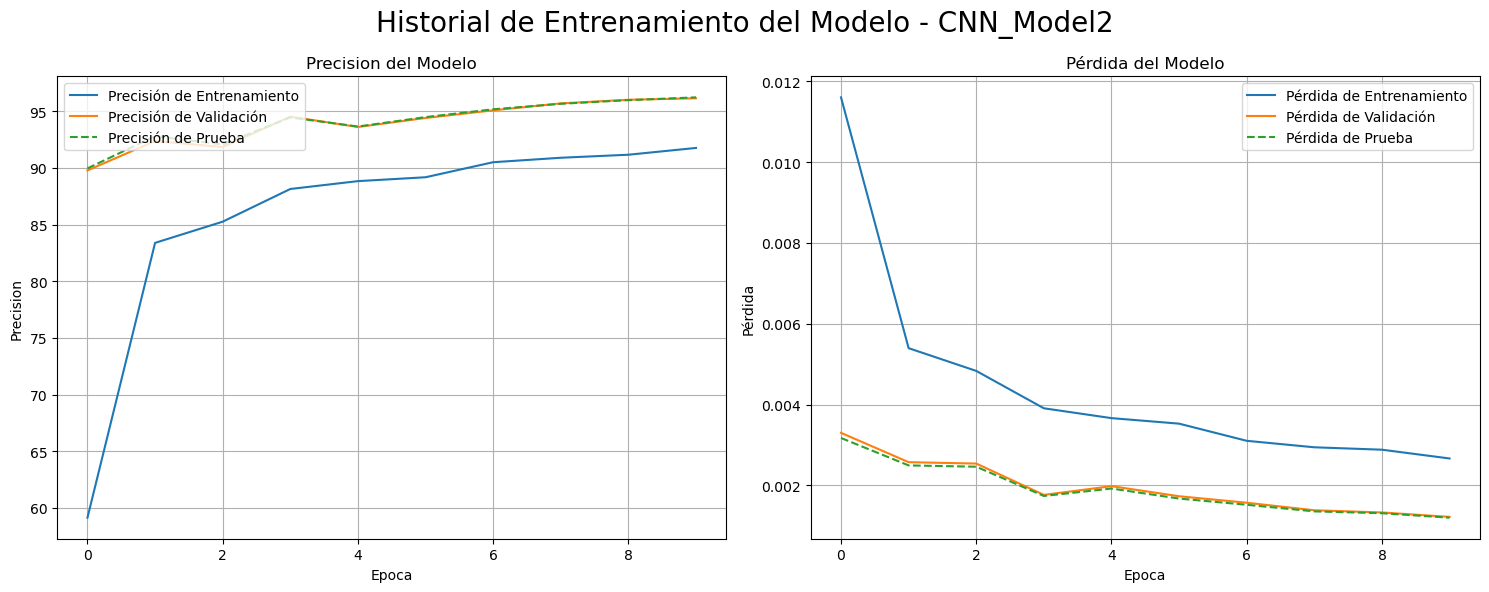

In [85]:
plot_history(train_loss2, val_loss2, test_loss2, train_accuracy2, val_accuracy2, test_accuracy2, 'CNN_Model2')

El gráfico histórico del `CNN_Model2` muestra una mejora constante en la precisión tanto en el conjunto de validación como en el de prueba a lo largo de las 10 épocas. La precisión de entrenamiento sigue subiendo, pero de manera más lenta después de la cuarta época, lo que sugiere que el modelo está alcanzando su capacidad máxima de aprendizaje. Por otro lado, la pérdida disminuye de forma sostenida, con una ligera estabilización en las últimas épocas, lo que indica un buen ajuste del modelo sin signos evidentes de sobreajuste.

El `CNN_Model2` logra un alto rendimiento en términos de precisión y reducción de pérdida, alcanzando un equilibrio óptimo entre estos factores alrededor de las últimas épocas. Este modelo demuestra ser más robusto y capaz de generalizar bien, aunque con un tiempo de entrenamiento mayor que el `CNN_Model1`.

#### Predicciones y Matriz de Confusion del Modelo

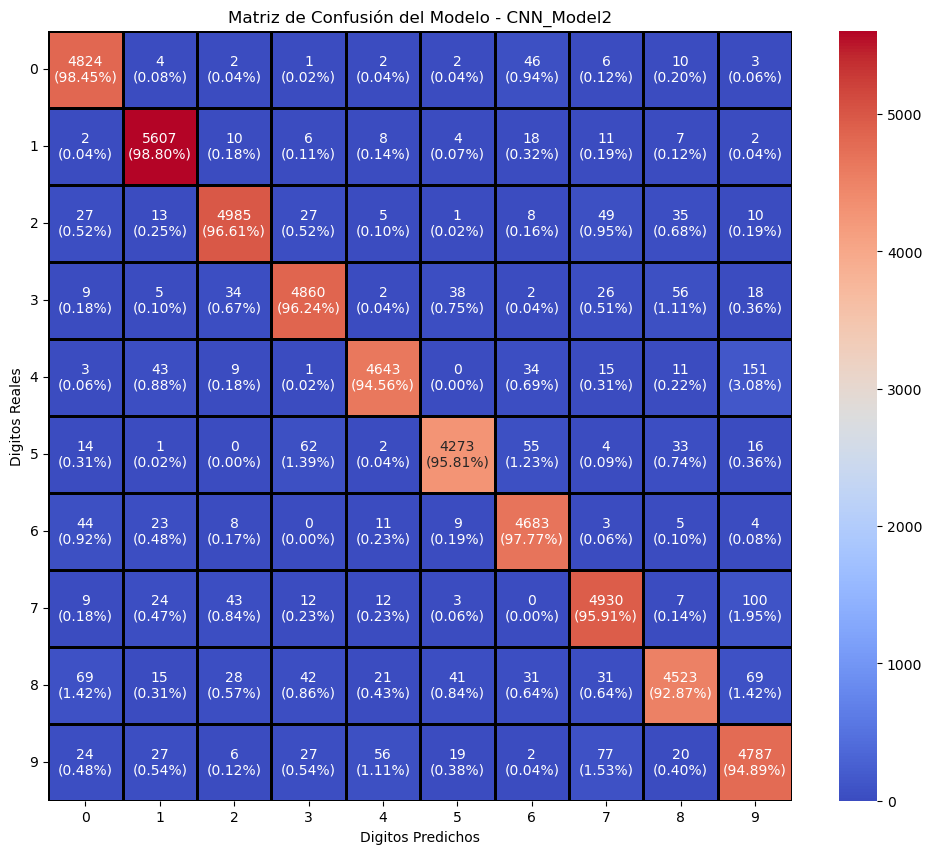

In [86]:
plot_confusion_matrix(y_test, test_preds2, epochs2, 'CNN_Model2')

La matriz de confusión del `CNN_Model2` muestra un excelente rendimiento en la mayoría de las clases, con precisiones superiores al **95%** para casi todos los dígitos. La mayor parte de las predicciones correctas se encuentran en la diagonal principal, lo que indica que el modelo clasifica correctamente la mayoría de las imágenes.

Sin embargo, todavía existen algunas confusiones, especialmente en dígitos como el 8, que se confunden más frecuentemente con otros dígitos. Aunque el modelo ha mejorado en comparación con `CNN_Model1`, estas confusiones siguen siendo un área potencial de mejora. En general, la matriz confirma que el `CNN_Model2` es robusto y preciso, con muy pocas confusiones, lo que refuerza la eficacia de su arquitectura más compleja.

#### Muestreo de Predicciones del Modelo

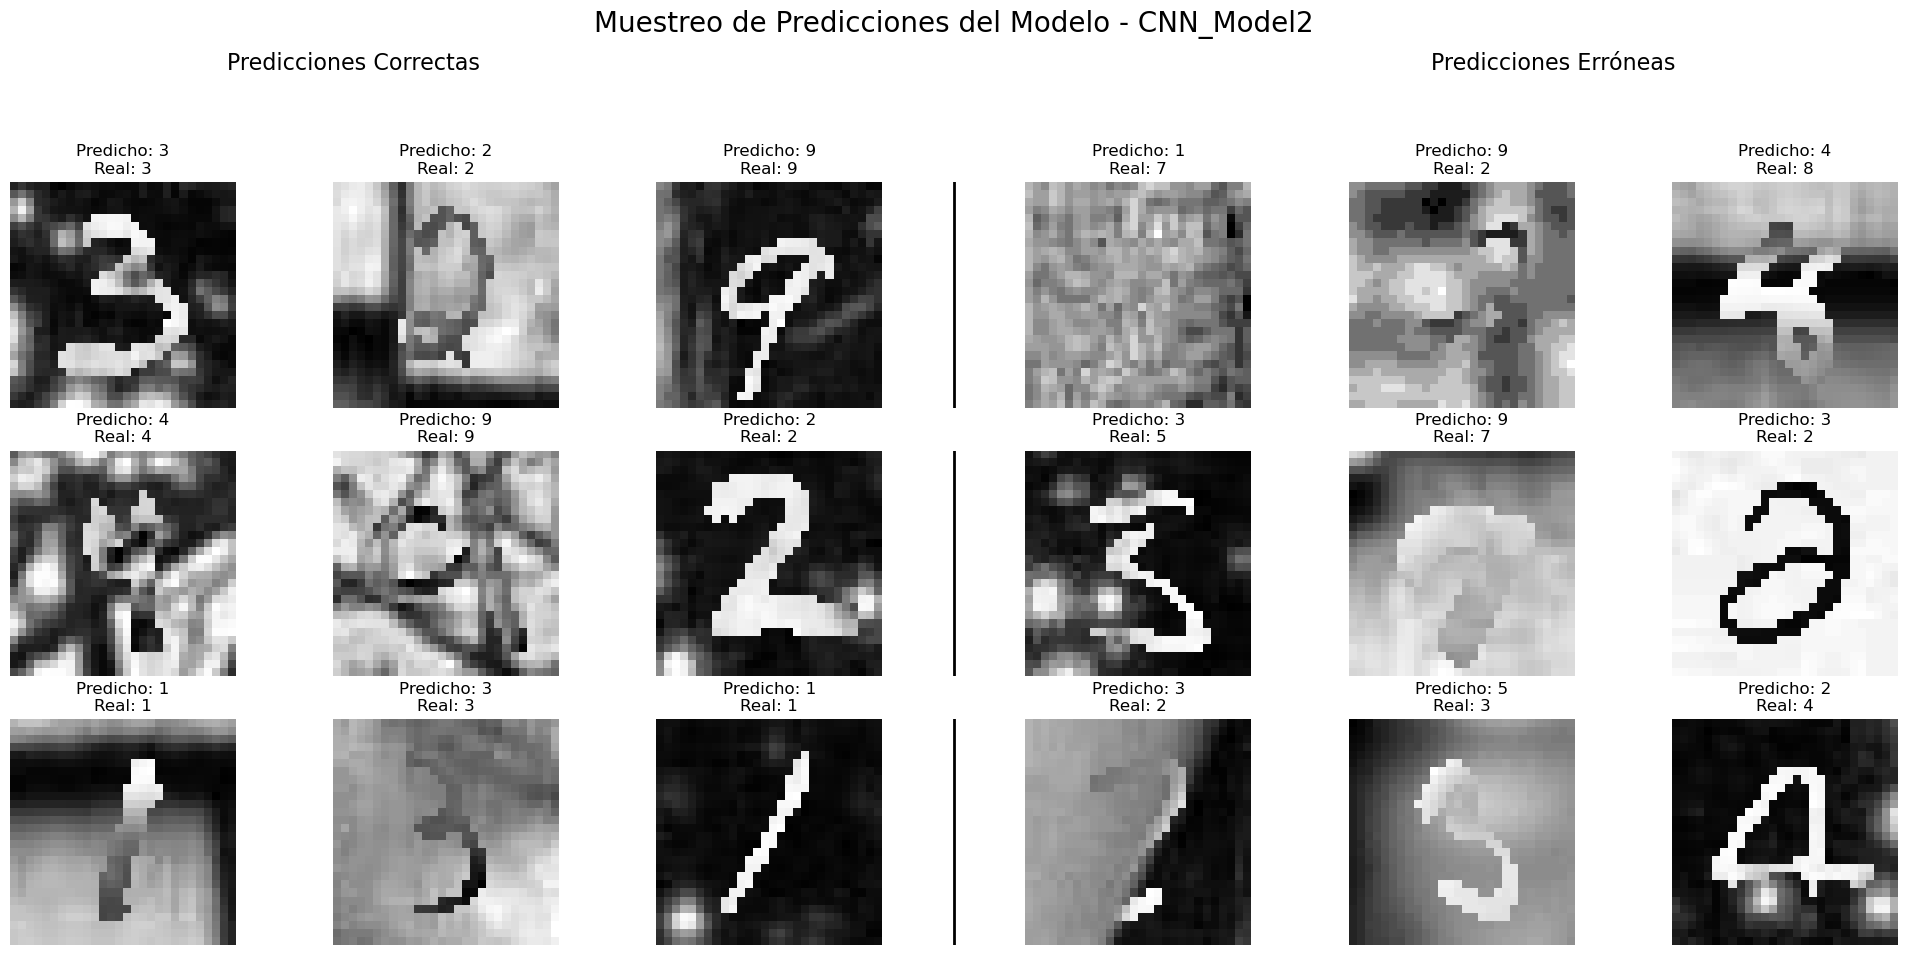

In [87]:
plot_predictions_sample(test_preds2, y_test, X_test, epochs2, 'CNN_Model2')

El muestreo de predicciones del `CNN_Model2` muestra que, aunque el modelo tiene un rendimiento sólido con muchas predicciones correctas, todavía hay algunas confusiones comprensibles. Las predicciones erróneas generalmente ocurren en imágenes con características visuales similares entre dígitos, o cuando las imágenes están distorsionadas o tienen bajo contraste.

Por ejemplo, el dígito 9 se confunde con un 4 en una imagen de baja calidad, y el 7 se confunde con un 2 en una imagen distorsionada. Esto indica que, aunque el modelo es más robusto y preciso, todavía enfrenta desafíos en situaciones donde la calidad de la imagen o la similitud entre dígitos es un factor determinante. Estos casos son comprensibles y reflejan las limitaciones naturales del modelo ante imágenes más complejas o menos claras.

### Guardar el Modelo

In [88]:
# Guardar el modelo entrenado
torch.save(model2.state_dict(), 'models/cnn_model2_no_augmentation.pth')

### Comparación de Modelos CNN

Al comparar los modelos `CNN_Model1` y `CNN_Model2`, se observa que ambos logran un alto nivel de precisión, lo que refleja su capacidad para clasificar correctamente los dígitos en el conjunto de datos. Sin embargo, la principal diferencia entre ellos radica en el balance entre precisión y tiempo de entrenamiento.

El `CNN_Model2` alcanza una mayor precisión, superando el **96%**, lo que lo posiciona como el modelo más preciso de los dos. Sin embargo, este incremento en la precisión conlleva un tiempo de entrenamiento considerablemente mayor, superando **1 minuto**. Este modelo resulta adecuado en situaciones donde se prioriza la máxima precisión y el tiempo de entrenamiento no es un factor limitante.

Por otro lado, el `CNN_Model1`, aunque ligeramente menos preciso (con una precisión que casi alcanza el **94%**), ofrece la ventaja de un tiempo de entrenamiento mucho más rápido, de aproximadamente **25 segundos**. Esta diferencia lo hace más eficiente en términos de recursos y más apropiado para entornos donde se requiere un entrenamiento rápido y eficiente, con una pequeña concesión en precisión.

Si la prioridad es maximizar la precisión y el tiempo de entrenamiento no es un factor crítico, el `CNN_Model2` sería la elección más adecuada. Sin embargo, para este caso, el tiempo de entrenamiento es una consideración importante y se puede aceptar una ligera disminución en precisión, el `CNN_Model1` es más conveniente debido a su eficiencia y rendimiento competitivo en menos tiempo. 

Por lo tanto, para fines prácticos, el `CNN_Model1` ofrece un mejor equilibrio entre precisión y tiempo de procesamiento.

## Red Neuronal Simple

Gracias a la modularidad del pipeline diseñado para Redes Neuronales, es posible adaptar un modelo de red neuronal simple o cualquier otra arquitectura de red para que sea compatible y se puedan reutilizar las utilidades existentes. El pipeline ha sido construido de manera flexible, lo que permite que diferentes tipos de modelos, desde redes neuronales simples hasta arquitecturas más complejas, puedan integrarse sin necesidad de reescribir el código base. La principal diferencia al incorporar una nueva red radicará en la arquitectura del modelo, mientras que el resto del pipeline, que incluye la carga de datos, el entrenamiento, la validación, y la evaluación, se mantiene consistente y eficiente, garantizando así la reproducibilidad y la facilidad de experimentación con diversas configuraciones de redes neuronales.

### Definicion de Arquitectura

Se define una arquitectura que:

- Tiene tres capas totalmente conectadas (lineales) que procesan la imagen aplanada de 28x28 píxeles.
- La primera capa reduce las 784 entradas a 128 neuronas, la segunda capa reduce de 128 a 64 neuronas, y la tercera capa genera las 10 salidas correspondientes a las clases de dígitos (0-9).
- Utiliza la función de activación ReLU después de cada capa para introducir no linealidad, permitiendo que el modelo aprenda patrones más complejos.
- Emplea dropout después de las dos primeras capas para reducir el riesgo de sobreajuste, manteniendo el modelo simple y generalizable.

A diferencia de las CNN utilizadas anteriormente, que emplean capas de convolución para extraer características espaciales y patrones locales de las imágenes, esta arquitectura es lineal y no tiene en cuenta la estructura espacial de los píxeles. Mientras que las CNN capturan relaciones espaciales complejas a través de convoluciones y pooling, esta red neuronal simple procesa la imagen como un vector plano, lo que la hace más rápida y menos demandante en términos computacionales, pero también menos capaz de capturar características visuales complejas.

In [53]:
class SimpleNN_Model(nn.Module):
    def __init__(self):
        super(SimpleNN_Model, self).__init__()
        
        # Capas totalmente conectadas (lineales)
        self.fc1 = nn.Linear(28 * 28, 128)  # Entrada: 784 (28x28), Salida: 128 neuronas
        self.relu1 = nn.ReLU()  # Función de activación ReLU
        self.dropout1 = nn.Dropout(0.25)  # Dropout para evitar sobreajuste
        
        self.fc2 = nn.Linear(128, 64)  # Entrada: 128, Salida: 64 neuronas
        self.relu2 = nn.ReLU()  # Función de activación ReLU
        self.dropout2 = nn.Dropout(0.25)  # Dropout para evitar sobreajuste
        
        self.fc3 = nn.Linear(64, 10)  # Capa de salida, 10 clases para los dígitos (0-9)

    def forward(self, x):
        # Aplanar la entrada para que sea compatible con la capa lineal
        x = x.view(x.size(0), -1)  # Aplanar la imagen de 28x28 a un vector de 784
        
        # Paso por la primera capa lineal
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        
        # Paso por la segunda capa lineal
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        
        # Paso por la capa de salida
        x = self.fc3(x)
        
        return x

### Instanciar Modelo

Se reutilizan los dataloaders y datasets definidos anteriormente, debido a la compatibilidad del pipeline.

In [54]:
model_simple, optimizer_simple, criterion_simple, exp_lr_scheduler_simple = instantiate_model(SimpleNN_Model)

CUDA DISPONIBLE: si
El modelo se entrenara con GPU: 
	NVIDIA GeForce RTX 3070 Ti Laptop GPU


### Entrenar y Validar Modelo

In [55]:
train_loss_simple, train_accuracy_simple, val_loss_simple, val_accuracy_simple, val_preds_simple, val_proba_simple, test_loss_simple, test_accuracy_simple, test_preds_simple, test_proba_simple = (
    train_validate_model(epochs=epochs1, 
                         model=model_simple,
                         train_loader=train_loader1,
                         val_loader=val_loader1,
                         test_loader=test_loader1,
                         criterion=criterion_simple,
                         optimizer=optimizer_simple,
                         exp_lr_scheduler=exp_lr_scheduler_simple,
                         batch_size=batch_size1)
)

Epoch: 01 | Time: 0m 4s
	Train Loss: 0.017 | Train Accuracy: 37.59
	 Val. Loss: 0.015 |  Val. Accuracy: 45.49
	 Test Loss: 0.015 |  Test Accuracy: 46.31
Epoch: 02 | Time: 0m 4s
	Train Loss: 0.016 | Train Accuracy: 45.65
	 Val. Loss: 0.014 |  Val. Accuracy: 54.37
	 Test Loss: 0.013 |  Test Accuracy: 55.37
Epoch: 03 | Time: 0m 4s
	Train Loss: 0.015 | Train Accuracy: 49.27
	 Val. Loss: 0.013 |  Val. Accuracy: 58.73
	 Test Loss: 0.013 |  Test Accuracy: 59.66
Epoch: 04 | Time: 0m 4s
	Train Loss: 0.014 | Train Accuracy: 53.56
	 Val. Loss: 0.012 |  Val. Accuracy: 64.85
	 Test Loss: 0.011 |  Test Accuracy: 65.63
Epoch: 05 | Time: 0m 4s
	Train Loss: 0.013 | Train Accuracy: 55.26
	 Val. Loss: 0.011 |  Val. Accuracy: 65.85
	 Test Loss: 0.011 |  Test Accuracy: 66.67


El entrenamiento de la red neuronal simple muestra un progreso constante en la precisión, pero de manera más gradual en comparación con los modelos CNN. A lo largo de cinco épocas, la precisión en el conjunto de entrenamiento aumentó desde aproximadamente un **37.59%** hasta un **55.26%**, mientras que la precisión en el conjunto de prueba se elevó de un **46.31%** a un **66.67%**. Esto indica que el modelo está aprendiendo, pero no al ritmo ni con la eficacia observada en los modelos CNN.

En comparación, los modelos CNN lograron una precisión significativamente mayor en tiempos similares, debido a su capacidad para capturar patrones espaciales complejos en las imágenes. La red neuronal simple, al no aprovechar estas características espaciales, requiere más iteraciones y entrenamiento para alcanzar un nivel de precisión que sigue siendo inferior al de las CNN. Sin embargo, su simplicidad y menor costo computacional la hacen adecuada para aplicaciones donde el tiempo de entrenamiento es crítico y se puede sacrificar cierta precisión.

### Historial de Rendimiento del modelo

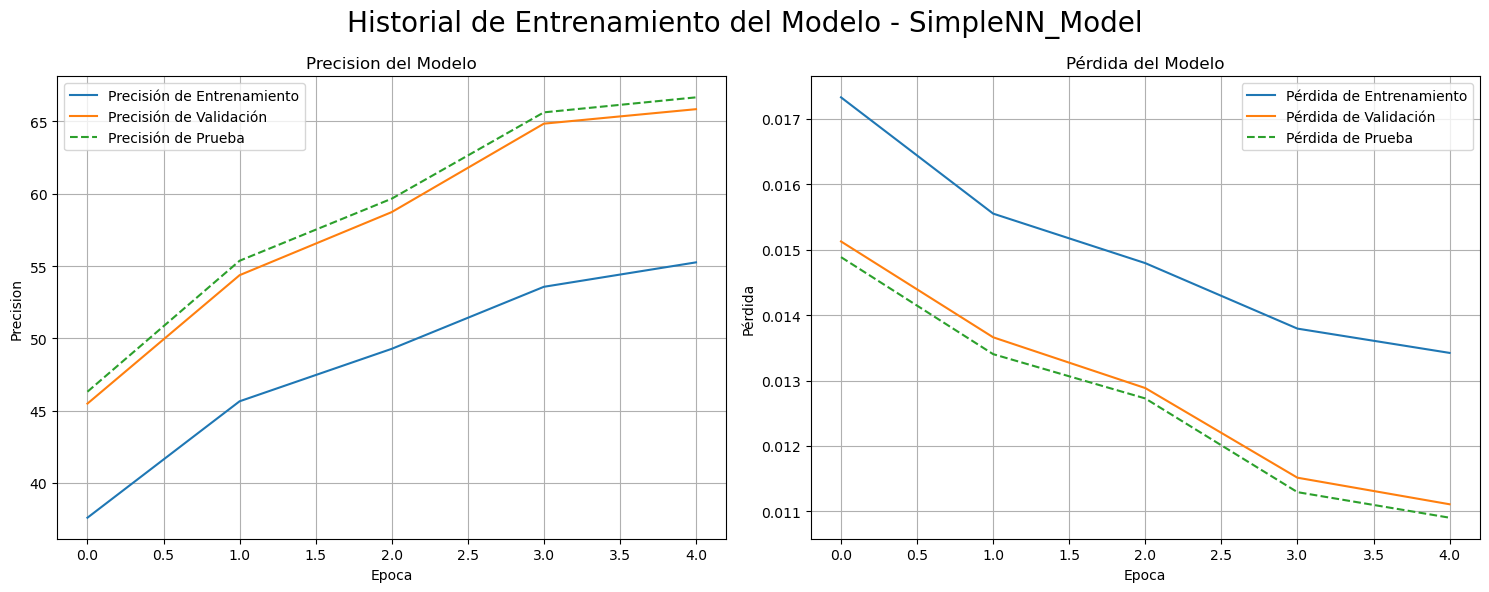

In [56]:
plot_history(train_loss_simple, val_loss_simple, test_loss_simple, train_accuracy_simple, val_accuracy_simple, test_accuracy_simple, 'SimpleNN_Model')

El gráfico del historial de entrenamiento del `SimpleNN_Model` muestra una mejora gradual en la precisión a lo largo de las épocas, tanto en el conjunto de entrenamiento como en los conjuntos de validación y prueba. Sin embargo, la tasa de aumento en la precisión es más lenta en comparación con las CNNs, y el modelo no alcanza los niveles de precisión observados en esas arquitecturas más complejas. La pérdida disminuye de manera consistente, lo que indica que el modelo está aprendiendo, pero a un ritmo más pausado y menos efectivo en la captura de patrones complejos, lo que se refleja en la precisión final, que es considerablemente menor que la de los modelos CNN. Asimismo se puede observar que las lineas de precisión y perdida estan disminuyendo su taza de crecimiento y disminucion conforme pasan las épocas indicando que el modelo esta alcanzando su máximo potencial.

### Predicciones y Matriz de Confusion del Modelo

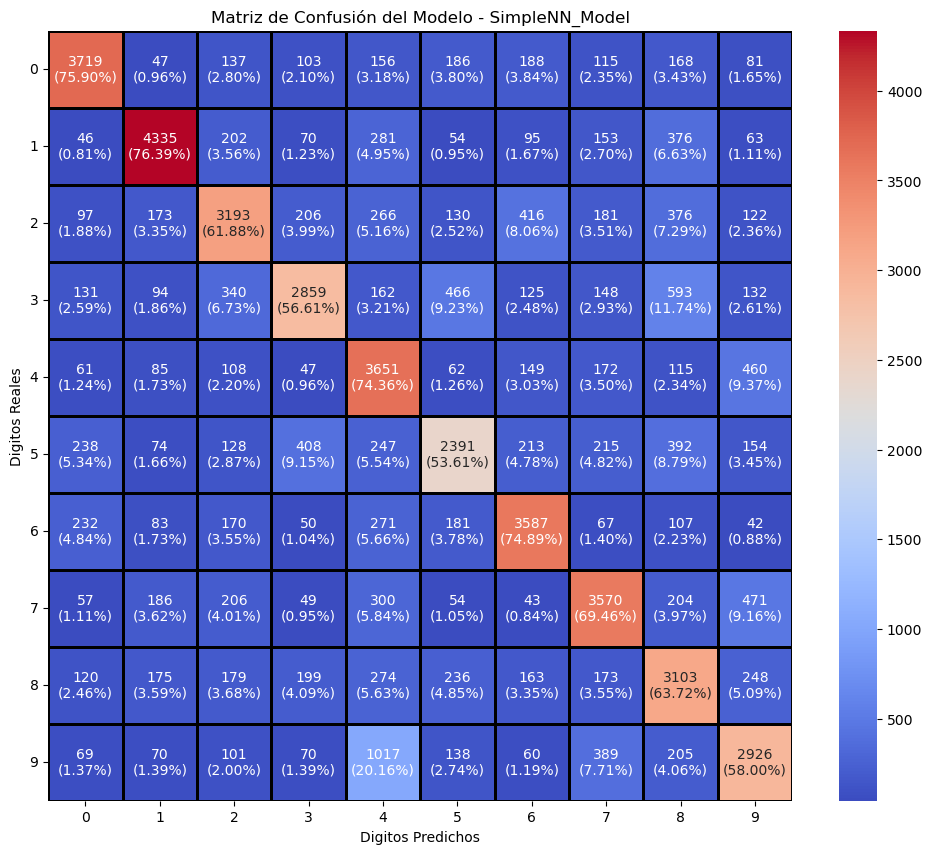

In [57]:
plot_confusion_matrix(y_test, test_preds_simple, epochs1, 'SimpleNN_Model')

La matriz de confusión del modelo `SimpleNN_Model` revela que el rendimiento de este modelo es notablemente inferior al de las CNNs previamente evaluadas. En varias clases de dígitos, el modelo tiene una tasa de precisión baja, con ejemplos claros en las clases como el dígito **9**, donde el modelo tiene una precisión de solo **58%**. Los errores de clasificación son más frecuentes y más dispersos, lo que indica que el modelo no está capturando bien las características distintivas de cada dígito. Esto es coherente con la simplicidad del modelo, que, al tener una arquitectura lineal más básica, carece de la capacidad de las CNNs para aprender y diferenciar patrones más complejos en los datos de entrada.

#### Muestreo de Predicciones del Modelo

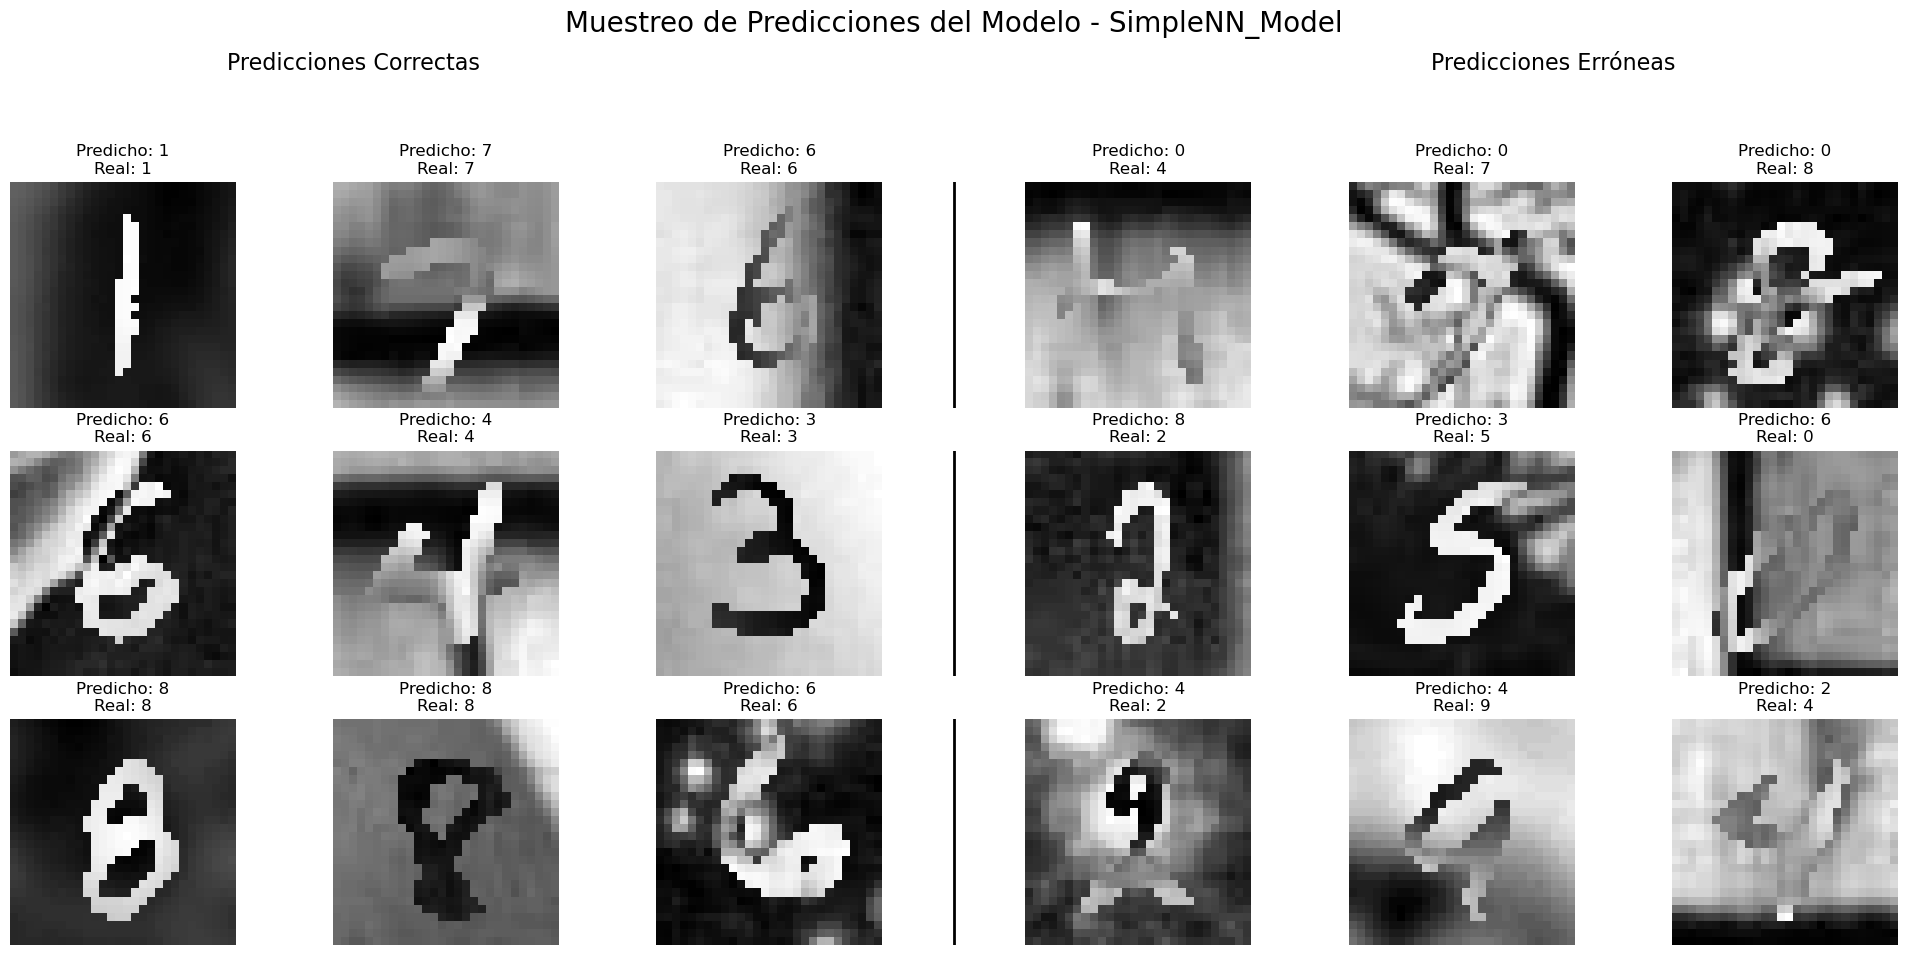

In [58]:
plot_predictions_sample(test_preds_simple, y_test, X_test, epochs1, 'SimpleNN_Model')

El muestreo de predicciones del modelo `SimpleNN_Model` revela varias áreas de mejora y algunas fortalezas. 

Por un lado, el modelo es capaz de hacer predicciones correctas en casos donde las imágenes son relativamente claras y bien definidas, como en los dígitos **0**, **4**, y **8**. Sin embargo, cuando las imágenes son menos claras o contienen ruido, el modelo tiende a cometer errores significativos. Esto es evidente en las predicciones erróneas, donde dígitos como el **8** y el **3** se confunden con otros debido a su forma similar o por el nivel de distorsión presente en la imagen.

En comparación con modelos más complejos, como las CNNs, este modelo simple tiene dificultades para capturar y diferenciar patrones sutiles en las imágenes, lo que conduce a una mayor tasa de error, especialmente en dígitos que presentan similitudes visuales. Esto refuerza la limitación de los modelos lineales en la tarea de clasificación de imágenes complejas, donde la capacidad para manejar características más abstractas y no lineales es crucial para un buen desempeño.

### Guardar el Modelo

In [59]:
# Guardar el modelo entrenado
torch.save(model_simple.state_dict(), 'models/simple_model_no_augmentation.pth')

## Data Augmentation

El data augmentation es una técnica clave para mejorar la generalización de los modelos de machine learning al aumentar la diversidad del conjunto de datos de entrenamiento. Al aplicar transformaciones aleatorias, como rotaciones, cambios de escala y ajustes de brillo, se genera un conjunto de datos más variado, lo que ayuda al modelo a aprender características más generales y reduce el riesgo de sobreajuste. Esto es especialmente útil en visión por computadora, donde se necesita que el modelo sea robusto ante variaciones que podría encontrar en aplicaciones del mundo real.

Al implementar data augmentation, se espera una mejora en la precisión del modelo, ya que se vuelve más capaz de manejar variaciones en las imágenes de entrada. Aunque esto puede aumentar el tiempo de entrenamiento, el beneficio de obtener un modelo más robusto y confiable generalmente justifica este costo adicional. En resumen, el data augmentation es una herramienta esencial para desarrollar modelos más efectivos y generalizables en entornos prácticos.

### Transformaciones

Se ha implementado un conjunto de transformaciones en PyTorch para preprocesar las imágenes de entrada de manera más robusta y realista. Estas transformaciones incluyen:

- **Resize:** Redimensiona todas las imágenes a un tamaño uniforme de 28x28 píxeles, asegurando consistencia en las dimensiones antes de que sean alimentadas al modelo, lo cual es crucial para el correcto funcionamiento de las redes neuronales.
- **Random Rotation:** Aplica una rotación aleatoria a las imágenes dentro de un rango de -10 a 10 grados. Esto emula las variaciones en el ángulo de captura que podrían ocurrir en aplicaciones reales, ayudando al modelo a volverse más resiliente ante dichas variaciones.
- **Color Jitter:** Introduce alteraciones aleatorias en la luminosidad, contraste, saturación y tinte de las imágenes. Esto refleja posibles cambios en las condiciones de iluminación y color durante la captura de las imágenes, permitiendo que el modelo aprenda a identificar los dígitos bajo diversas condiciones visuales.

Estas transformaciones fueron seleccionadas porque introducen variaciones significativas pero realistas, lo que ayuda al modelo a aprender a reconocer patrones importantes incluso cuando las imágenes presentan diferencias sutiles en ángulos o condiciones de iluminación. Así, el modelo se entrena en un entorno más cercano al mundo real, mejorando su capacidad de generalización y reduciendo el riesgo de sobreajuste a condiciones de entrenamiento muy específicas.

In [60]:
augmentation_transforms = transforms.Compose([
    # Redimensionar las imágenes a 28x28 píxeles
    transforms.Resize((28, 28)),
    # Rotar aleatoriamente las imágenes hasta 10 grados
    transforms.RandomRotation(10),
    # Aplicar jittering de color
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    # Convertir la imagen a un tensor de PyTorch
    transforms.ToTensor()
])

### Directorio Nuevo

In [61]:
def create_directories(base_path):
    """
    Crear directorios para las modalidades de las imágenes.

    Args:
        base_path (str): Ruta base donde se crearán los directorios.

    Returns:
        None
    """
    if not os.path.exists(base_path):
        os.makedirs(base_path)
    for modality in ['m0', 'm1', 'm2', 'm3', 'm4']:
        os.makedirs(os.path.join(base_path, modality), exist_ok=True)

### Aplicar transformaciones

In [62]:
def augment_and_save_images(original_dataset_dir, augmented_dataset_dir, transform, aug_qty=1000 ):
    """
    Aplicar transformaciones a las imágenes y guardar las imágenes augmentadas.

    Args:
        original_dataset_dir (str): Ruta del directorio con las imágenes originales.
        augmented_dataset_dir (str): Ruta del directorio donde se guardarán las imágenes augmentadas.
        transform (torchvision.transforms.Compose): Transformaciones a aplicar a las imágenes.
        aug_qty (int): Cantidad de imágenes augmentadas a generar por cada modalidad.        
    Returns:
        None
    """
    # Asegurar que se generen la misma cantidad de imágenes por dígito
    images_per_digit = aug_qty // 10  
    
    # Crear directorios para las modalidades de las imágenes augmentadas
    for modality in ['m0', 'm1', 'm2', 'm3', 'm4']:
        modality_dir = os.path.join(original_dataset_dir, modality)
        save_dir = os.path.join(augmented_dataset_dir, modality)
        
        # Obtener la lista de imágenes en la modalidad y organizarlas por dígito
        images_by_digit = defaultdict(list)
        all_images = [f for f in os.listdir(modality_dir) if f.endswith('.png')]
        for filename in all_images:
            digit = int(filename.split('.')[1])  # el formato "index.digit.png"
            images_by_digit[digit].append(filename)
        
        # Guardar todas las imágenes originales
        for filename in tqdm(all_images, desc=f'Guardando originales de {modality}', unit=' imagen'):
            img_path = os.path.join(modality_dir, filename)
            image = Image.open(img_path).convert("RGB")
            save_path = os.path.join(save_dir, filename)
            image.save(save_path)
        
        # Aplicar augmentación para cada dígito de forma balanceada
        for digit, filenames in images_by_digit.items():
            selected_images = random.sample(filenames, min(len(filenames), images_per_digit))
            
            for filename in tqdm(selected_images, desc=f'Augmentando {modality} - Dígito {digit}', unit=' imagen'):
                img_path = os.path.join(modality_dir, filename)
                image = Image.open(img_path).convert("RGB")
                
                for _ in range(images_per_digit // len(selected_images)):
                    augmented_image = transform(image)
                    unique_filename = f"aug_{digit}_{uuid.uuid4().hex}_{filename}"
                    save_path = os.path.join(save_dir, unique_filename)
                    augmented_image_pil = transforms.ToPILImage()(augmented_image)
                    augmented_image_pil.save(save_path)

### Generar el conjunto aumentado o Cargarlo

In [63]:
if not os.path.exists('dataset_augmented/train'):
    # Crear directorios para las imágenes aumentadas    
    print("Creando directorios para las imágenes aumentadas...")
    create_directories('dataset_augmented/train')
    print("\nEXITO: Directorios creados.")

    # Aumentar las imágenes de entrenamiento
    print("\nAumentando las imágenes de entrenamiento...")
    augment_and_save_images('dataset/train', 'dataset_augmented/train', augmentation_transforms)
    print("\nEXITO: Imágenes de entrenamiento aumentadas.")

else:
    # Las imágenes de entrenamiento aumentadas ya existen
    print("Las imágenes de entrenamiento aumentadas ya existen.")
    print("Se omite la augmentación de imágenes de entrenamiento.")

Creando directorios para las imágenes aumentadas...

EXITO: Directorios creados.

Aumentando las imágenes de entrenamiento...


Augmentando m4 - Dígito 9: 100%|██████████| 100/100 [00:00<00:00, 670.28 imagen/s]



EXITO: Imágenes de entrenamiento aumentadas.


### Visualizar Distribucion del Dataset Aumentado

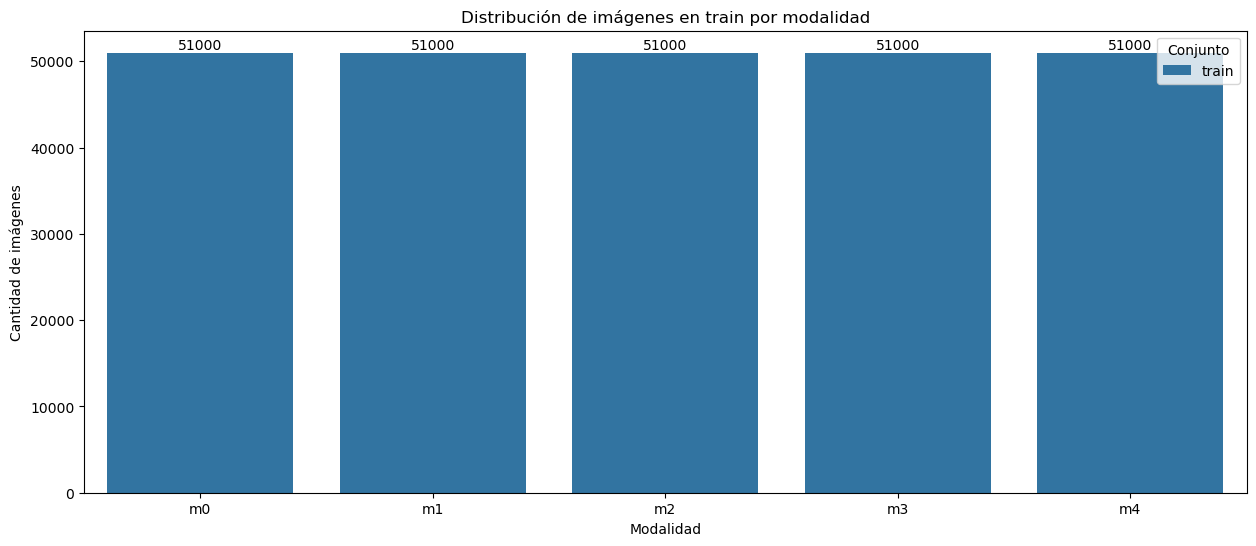

In [64]:
# Contar las imágenes por dígito y modalidad
df_counts = count_images_by_digit_and_mode('dataset_augmented', ['train'])

# Graficar la distribución de imágenes en train y test por modalidad
plt.figure(figsize=(15, 6))
ax = sns.countplot(data=df_counts, x='modality', hue='mode')

# Etiquetas en las barras con la cantidad de imágenes
for container in ax.containers:
    ax.bar_label(container)

# Configuración de la gráfica
plt.title('Distribución de imágenes en train por modalidad')
plt.legend(title='Conjunto')
plt.xlabel('Modalidad')
plt.ylabel('Cantidad de imágenes')
plt.show()

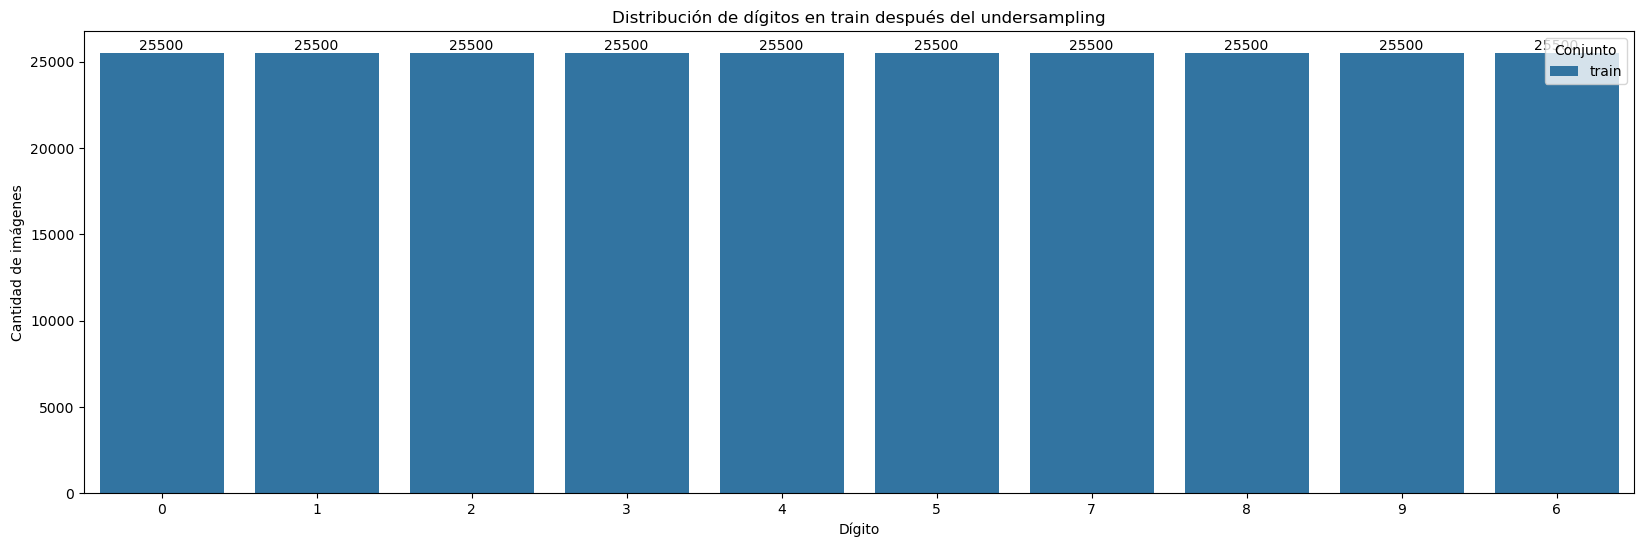

In [65]:
# Contar las imágenes por dígito y modalidad
df_counts = count_images_by_digit_and_mode('dataset_augmented', ['train'])

# Graficar la distribución de dígitos en general en train y test
plt.figure(figsize=(20, 6))
ax = sns.countplot(data=df_counts, x='digit', hue='mode')

# Etiquetas en las barras con la cantidad de imágenes
for container in ax.containers:
    ax.bar_label(container)

# Configuración de la gráfica
plt.title('Distribución de dígitos en train después del undersampling')
plt.legend(title='Conjunto', loc='upper right')
plt.xlabel('Dígito')
plt.ylabel('Cantidad de imágenes')
plt.show()

Se optó por aplicar un aumento de datos moderado, dado que el dataset original ya cuenta con un tamaño significativo de **250,000 imágenes**. Incrementar el dataset a través de transformaciones en todas las imágenes hubiera resultado en un uso excesivo de recursos computacionales, sin aportar un beneficio sustancial, ya que los modelos entrenados previamente ya han mostrado un rendimiento sólido. Aunque aplicar augmentation a todo el dataset podría mejorar la capacidad de generalización del modelo, para los propósitos de esta práctica no era necesario. 

Por esta razón, se decidió agregar **5,000 imágenes augmentadas** en total, distribuidas en **1,000 imágenes** adicionales por modalidad, lo que se traduce en **100 imágenes** por dígito, asegurando así el balanceo de clases. Esto permite incrementar la diversidad del conjunto de entrenamiento sin sobrecargar el procesamiento. Como resultado, el conjunto de entrenamiento ahora cuenta con **255,000 imágenes**, lo que es suficiente para explorar las ventajas del data augmentation sin comprometer la eficiencia del entrenamiento.

### Guardado del dataset como CSV

In [66]:
if not os.path.exists('data/train_augmented.csv'):
    print("Procesando el conjunto de datos de entrenamiento aumentado...")
    augmented_train_df = process_dataset('dataset_augmented/train', 'data/train_augmented.csv')
    print("\nEXITO: Conjunto de datos de entrenamiento aumentado procesado ")
else:
    print("Archivo 'train_augmented.csv' ya existe. Se omite el procesamiento.")
    print("\nCargando el archivo 'train_augmented.csv'...")
    augmented_train_df = pd.read_csv('data/train_augmented.csv', dtype=np.float32)
    print("\nEXITO: Conjunto de datos de entrenamiento aumentado cargado.")

Procesando el conjunto de datos de entrenamiento aumentado...


Procesando dataset_augmented/train: 100%|██████████| 255000/255000 [13:14<00:00, 321.10 imagen/s]



Generando columnas de dataframe...

Generando DataFrame...

EXITO: DataFrame generado y guardado en 'data/train_augmented.csv'.

EXITO: Conjunto de datos de entrenamiento aumentado procesado 


## Modelo CNN con Datos aumentados

Se utilizará el `CNN_Model1`, previamente definido, ya que ha sido identificado como el modelo de mejor rendimiento. Este modelo será entrenado nuevamente utilizando el conjunto de datos aumentado para evaluar las diferencias en su desempeño con respecto al entrenamiento previo.

### Crear Data Loaders

Para fines de comparación, se ha decidido utilizar la misma cantidad de épocas en el entrenamiento del `CNN_Model1` con el conjunto de datos aumentado. Esto permite una evaluación directa del impacto del data augmentation en el rendimiento del modelo. Además, se mantuvo la cantidad de épocas porque, en experimentos previos, se observó que aumentar las épocas no generaba mejoras significativas en el rendimiento, lo que no justifica el costo computacional adicional.

In [67]:
# Definir hiperparámetros
batch_size1a = 100        # Tamaño del lote
n_iter1a = 2500           # Número de iteraciones
epochs1a = 5              # Número de épocas

X_train1a, y_train1a, X_val1a, y_val1a, X_test1a, y_test1a = preprocessing(augmented_train_df, test_df)

train_loader1a, val_loader1a, test_loader1a = get_data_loaders(X_train=X_train1a, 
                                                         y_train=y_train1a, 
                                                         X_val=X_val1a, 
                                                         y_val=y_val1a, 
                                                         X_test=X_test1a,
                                                         y_test=y_test1a, 
                                                         batch_size=batch_size1a)

Dimensiones de los datos de entrenamiento: torch.Size([204000, 784])

Dimensiones de las etiquetas de entrenamiento: torch.Size([204000])

Dimensiones de los datos de validación: torch.Size([51000, 784])

Dimensiones de las etiquetas de validación: torch.Size([51000])

Dimensiones de los datos de prueba: torch.Size([50000, 784])

Dimensiones de las etiquetas de prueba: torch.Size([50000])


### Instanciar modelo

In [68]:
model1a, optimizer1a, criterion1a, exp_lr_scheduler1a = instantiate_model(CNN_Model1)

CUDA DISPONIBLE: si
El modelo se entrenara con GPU: 
	NVIDIA GeForce RTX 3070 Ti Laptop GPU


### Entrenar y validar el modelo

In [69]:
train_loss1a, train_accuracy1a, val_loss1a, val_accuracy1a, val_preds1a, val_proba1a, test_loss1a, test_accuracy1a, test_preds1a, test_proba1a = (
    train_validate_model(epochs=epochs1a, 
                         model=model1a,
                         train_loader=train_loader1a,
                         val_loader=val_loader1a,
                         test_loader=test_loader1a,
                         criterion=criterion1a,
                         optimizer=optimizer1a,
                         exp_lr_scheduler=exp_lr_scheduler1a,
                         batch_size=batch_size1a)
)

Epoch: 01 | Time: 0m 6s
	Train Loss: 0.006 | Train Accuracy: 82.20
	 Val. Loss: 0.003 |  Val. Accuracy: 90.41
	 Test Loss: 0.003 |  Test Accuracy: 90.29
Epoch: 02 | Time: 0m 6s
	Train Loss: 0.004 | Train Accuracy: 86.59
	 Val. Loss: 0.003 |  Val. Accuracy: 91.81
	 Test Loss: 0.003 |  Test Accuracy: 91.81
Epoch: 03 | Time: 0m 6s
	Train Loss: 0.004 | Train Accuracy: 87.68
	 Val. Loss: 0.003 |  Val. Accuracy: 91.96
	 Test Loss: 0.003 |  Test Accuracy: 91.84
Epoch: 04 | Time: 0m 5s
	Train Loss: 0.003 | Train Accuracy: 89.59
	 Val. Loss: 0.002 |  Val. Accuracy: 93.94
	 Test Loss: 0.002 |  Test Accuracy: 93.76
Epoch: 05 | Time: 0m 5s
	Train Loss: 0.003 | Train Accuracy: 89.89
	 Val. Loss: 0.002 |  Val. Accuracy: 93.66
	 Test Loss: 0.002 |  Test Accuracy: 93.62


El entrenamiento del `CNN_Model1` con datos aumentados muestra un rendimiento ligeramente superior en comparación con el entrenamiento sin augmentation. Desde la primera época, se observa una mejora en la precisión tanto en el conjunto de validación como en el conjunto de prueba, aunque las diferencias no son drásticas. A medida que avanza el entrenamiento, el modelo con augmentation logra una precisión de prueba de **93.62%** en la quinta época, superando el **93.46%** alcanzado sin augmentation. 

Estas mejoras, aunque pequeñas, sugieren que el data augmentation ayuda al modelo a generalizar mejor, especialmente en las últimas épocas. Sin embargo, el aumento en la precisión es modesto, lo que indica que el conjunto de datos original ya era lo suficientemente variado y que el beneficio adicional del augmentation es limitado, especialmente considerando el tiempo de entrenamiento similar.

### Gráficos de Resultados

#### Historial de Rendimiento del modelo

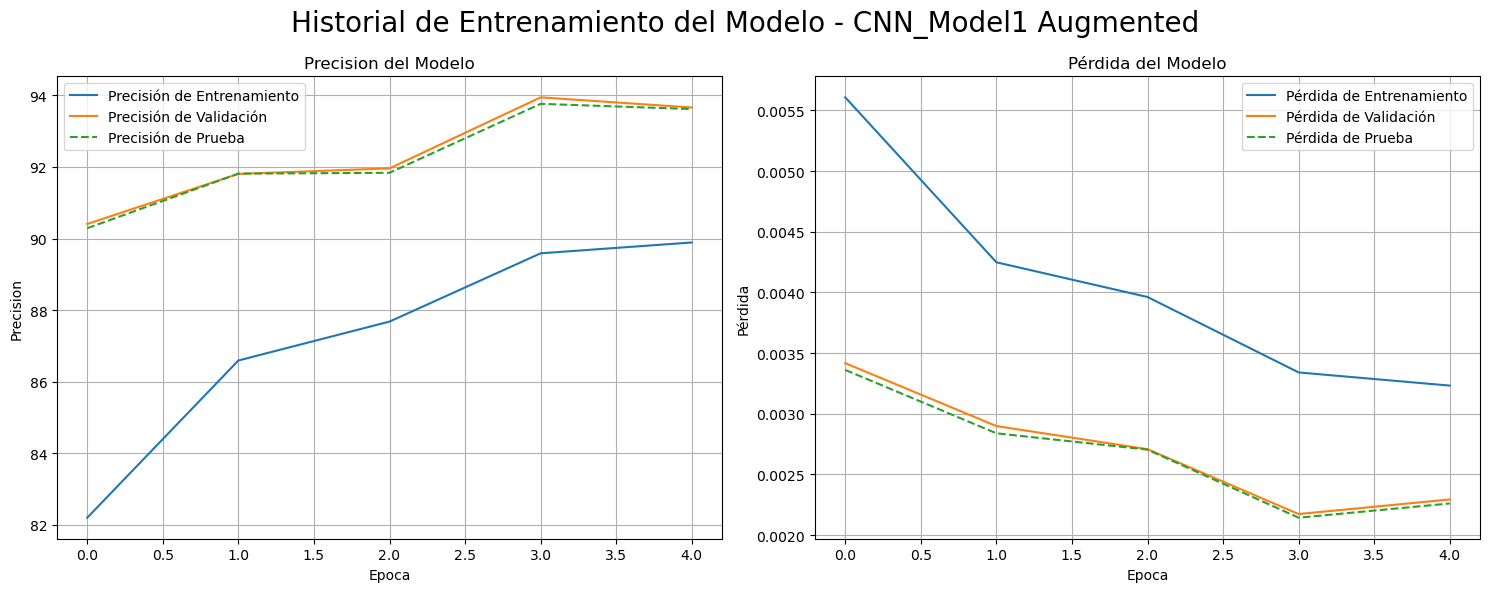

In [70]:
plot_history(train_loss1a, 
             val_loss1a, 
             test_loss1a, 
             train_accuracy1a, 
             val_accuracy1a, 
             test_accuracy1a, 
             'CNN_Model1 Augmented')

El historial de entrenamiento del `CNN_Model1` con datos aumentados muestra una tendencia positiva tanto en precisión como en reducción de la pérdida a lo largo de las épocas. Desde la primera época, se observa que el modelo se beneficia del aumento de datos, alcanzando una precisión ligeramente superior en comparación con la versión sin augmentation.

A lo largo de las cinco épocas, el modelo mantiene un crecimiento constante en la precisión de entrenamiento, validación y prueba, con una mejora continua en la pérdida. La precisión final en el conjunto de prueba es mayor que la obtenida sin augmentation, lo que indica que el modelo ha logrado aprender de manera más efectiva gracias a la mayor diversidad en los datos. Sin embargo, la diferencia en la mejora no es tan significativa, lo que reafirma que el dataset original ya estaba bien preparado para entrenar el modelo. Esto sugiere que, aunque el data augmentation ha tenido un efecto positivo, el impacto no es drástico, pero sí contribuye a una mejor generalización del modelo.

#### Predicciones y Matriz de Confusion del Modelo

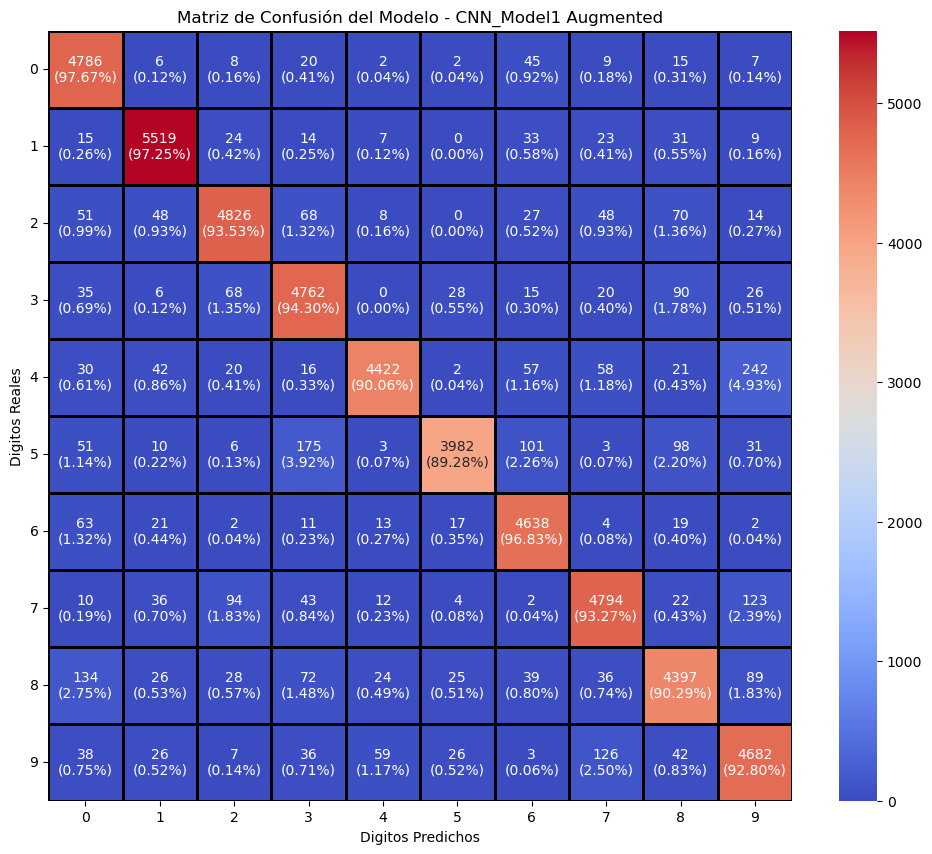

In [71]:
plot_confusion_matrix(y_test1a, test_preds1a, epochs1a, 'CNN_Model1 Augmented')

La matriz de confusión para el `CNN_Model1` entrenado con datos aumentados muestra una mejora notable en la precisión de clasificación en comparación con el modelo sin datos aumentados. Varios dígitos, como el 0, 1 y 2, presentan una alta precisión, con tasas de acierto superiores al **95%**. Esto sugiere que el aumento de datos ha permitido al modelo aprender características más robustas, reduciendo los errores en la clasificación de estos dígitos.

Sin embargo, algunos dígitos como el 4, 5, 8 y 9 siguen mostrando cierta confusión con otros dígitos, aunque la precisión ha mejorado ligeramente. En general, la matriz indica que el data augmentation ha contribuido a una mayor generalización del modelo, especialmente en dígitos que previamente presentaban un mayor grado de error. Esto refuerza la idea de que, aunque el impacto del aumento no fue drástico, sí proporcionó un beneficio adicional en la precisión de ciertas clases.

#### Muestreo de Predicciones del Modelo

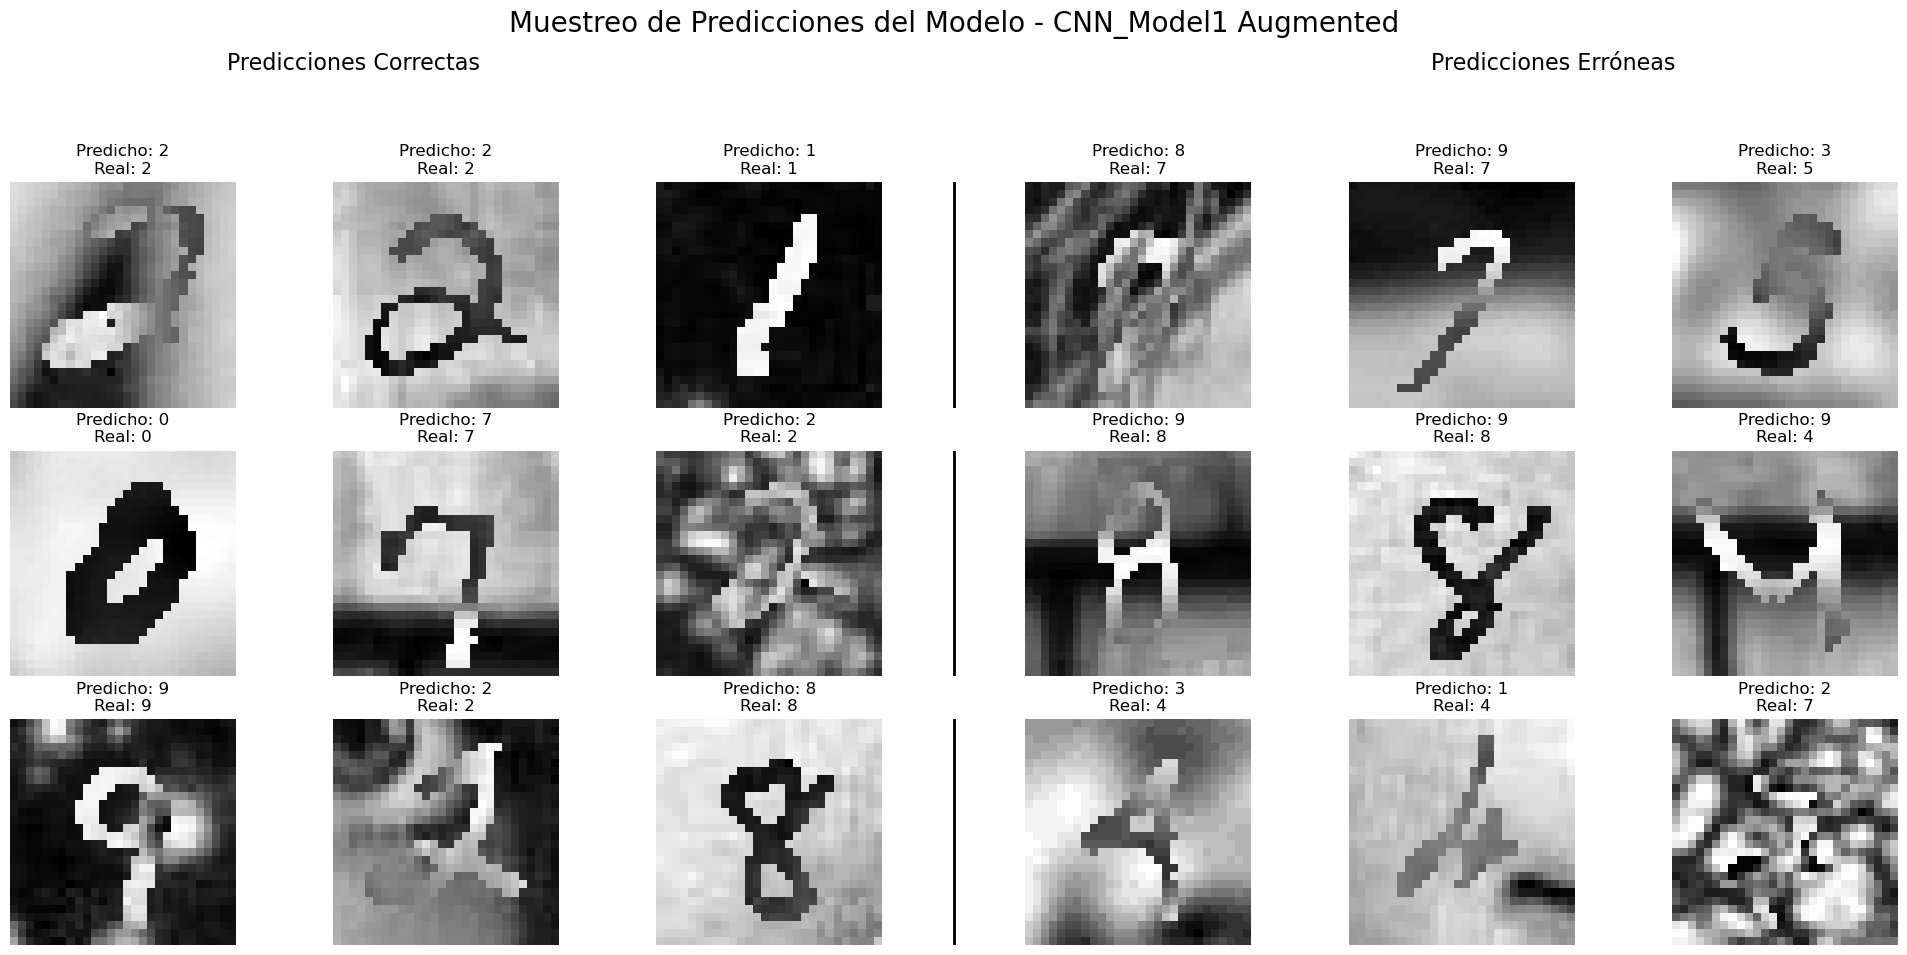

In [72]:
plot_predictions_sample(test_preds1a, y_test1a, X_test1a, epochs1a, 'CNN_Model1 Augmented')

El muestreo de predicciones para el `CNN_Model1` entrenado con datos aumentados muestra una mezcla de aciertos y errores que reflejan las mejoras y limitaciones del modelo tras aplicar el data augmentation. En las predicciones correctas, se observa que el modelo es capaz de identificar correctamente dígitos con diferentes estilos y niveles de ruido, lo que sugiere que el data augmentation ha contribuido a mejorar la robustez del modelo frente a variaciones en las imágenes.

Sin embargo, las predicciones erróneas revelan que algunos dígitos, especialmente aquellos con formas similares o imágenes de baja calidad, siguen siendo problemáticos para el modelo. Por ejemplo, el dígito 5 se confunde con el 3 y el 8 en varias ocasiones, lo que sugiere que, aunque el modelo ha mejorado en general, aún hay casos donde las características visuales similares o el ruido en la imagen conducen a errores. Este análisis confirma que, aunque el data augmentation ha sido beneficioso, el modelo podría requerir ajustes adicionales o un mayor entrenamiento para mejorar su precisión en estos casos más difíciles.

#### Guardar el modelo

In [73]:
# Guardar el modelo entrenado
torch.save(model1a.state_dict(), 'models/cnn_model1_augmentation.pth')

#### Comparación de Rendimiento del modelo con datos aumentados vs originales

Al comparar el desempeño del `CNN_Model1` entrenado con el conjunto de datos original versus el conjunto de datos aumentado, se pueden observar varias diferencias clave que arrojan luz sobre el impacto del data augmentation en el rendimiento del modelo.

El modelo entrenado con el conjunto de datos original ya mostró un rendimiento bastante sólido, alcanzando una precisión de alrededor del **93.46%** en el conjunto de prueba. Sin embargo, al introducir el data augmentation, aunque ligero, el modelo mejoró ligeramente su precisión hasta aproximadamente **93.62%**. Esta mejora, aunque no drástica, sugiere que el data augmentation contribuyó a una mejor generalización del modelo, ayudándolo a manejar mejor las variaciones en los datos de prueba.

El data augmentation utilizado fue relativamente modesto, añadiendo solo **5,000 imágenes** al conjunto de datos original, distribuidas uniformemente entre las diferentes clases de dígitos. A pesar de esta cantidad moderada, se puede ver que incluso un incremento pequeño en la diversidad de los datos de entrenamiento puede ayudar al modelo a mejorar ligeramente su rendimiento. No obstante, el impacto de este aumento en el conjunto de datos no es revolucionario, ya que la precisión mejoró menos de un **1%**, lo que indica que el modelo original ya estaba bien ajustado al problema.

## Modelo NN Simple con datos aumentados

Se utilizarán los mismos data loaders previamente definidos para el modelo `CNN_Model1`, aprovechando la modularidad y compatibilidad del pipeline diseñado. 

### Instanciar Modelo aumentado

In [74]:
model_simple_a, optimizer_simple_a, criterion_simple_a, exp_lr_scheduler_simple_a = instantiate_model(SimpleNN_Model)

CUDA DISPONIBLE: si
El modelo se entrenara con GPU: 
	NVIDIA GeForce RTX 3070 Ti Laptop GPU


### Entrenar y Validar el Modelo

In [75]:
# Entrenar y validar el modelo simple con los datos aumentados
train_loss1a, train_accuracy1a, val_loss1a, val_accuracy1a, val_preds1a, val_proba1a, test_loss1a, test_accuracy1a, test_preds1a, test_proba1a = (
    train_validate_model(epochs=epochs1a, 
                         model=model_simple_a,
                         train_loader=train_loader1a,
                         val_loader=val_loader1a,
                         test_loader=test_loader1a,
                         criterion=criterion_simple_a,
                         optimizer=optimizer_simple_a,
                         exp_lr_scheduler=exp_lr_scheduler_simple_a,
                         batch_size=batch_size1a)
)

Epoch: 01 | Time: 0m 4s
	Train Loss: 0.017 | Train Accuracy: 41.58
	 Val. Loss: 0.013 |  Val. Accuracy: 56.81
	 Test Loss: 0.013 |  Test Accuracy: 57.91
Epoch: 02 | Time: 0m 4s
	Train Loss: 0.014 | Train Accuracy: 52.72
	 Val. Loss: 0.012 |  Val. Accuracy: 63.09
	 Test Loss: 0.012 |  Test Accuracy: 64.67
Epoch: 03 | Time: 0m 4s
	Train Loss: 0.013 | Train Accuracy: 55.83
	 Val. Loss: 0.011 |  Val. Accuracy: 65.83
	 Test Loss: 0.011 |  Test Accuracy: 66.76
Epoch: 04 | Time: 0m 4s
	Train Loss: 0.013 | Train Accuracy: 59.51
	 Val. Loss: 0.011 |  Val. Accuracy: 67.03
	 Test Loss: 0.010 |  Test Accuracy: 68.20
Epoch: 05 | Time: 0m 4s
	Train Loss: 0.012 | Train Accuracy: 60.31
	 Val. Loss: 0.010 |  Val. Accuracy: 68.95
	 Test Loss: 0.010 |  Test Accuracy: 69.73


El entrenamiento del `SimpleNN_Model` con el conjunto de datos aumentado logró mejorar significativamente el rendimiento del modelo; aumentando la precisión desde un **57.91%** inicial, alcanzando un **69.73%** en el conjunto de prueba. Esto sugiere que, el haber introducido nuevas variaciones en los datos mediante data augmentation, la arquitectura simple de la red fue capaz de capitalizar estas variaciones. Sin embargo, la precisión sigue siendo relativamente baja en comparacion con las CNN. Este resultado resalta la importancia de ajustar la complejidad del modelo en función de la naturaleza del dataset, ya que un modelo más simple puede no ser suficiente para aprovechar completamente el aumento de datos y mejorar la generalización.

### Gráficos de Resultados

#### Historial de Rendimiento del modelo

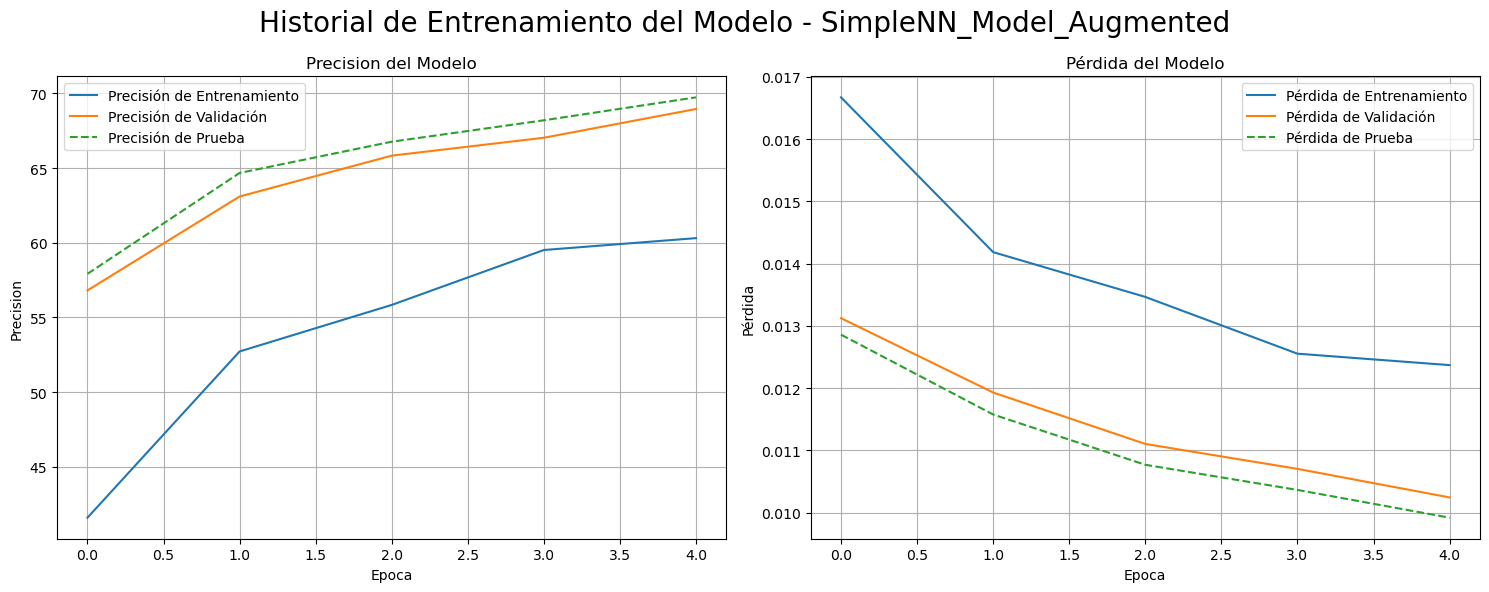

In [76]:
plot_history(train_loss1a, val_loss1a, test_loss1a, train_accuracy1a, val_accuracy1a, test_accuracy1a, 'SimpleNN_Model_Augmented')

El historial de entrenamiento del `SimpleNN_Model` con datos aumentados muestra un progreso constante en términos de precisión tanto para el conjunto de validación como para el de prueba, aunque con una mejora limitada. La precisión del modelo se estabiliza alrededor del **69%**, lo que indica que el aumento de datos no logró una mejora significativa en la capacidad del modelo para generalizar. La pérdida también muestra una disminución constante, lo que sugiere que el modelo sigue aprendiendo, pero no lo suficiente como para traducirse en un rendimiento significativamente mejorado. Esto refuerza la idea de que, para arquitecturas más simples, el impacto del data augmentation puede ser limitado.

#### Predicciones y Matriz de Confusion del Modelo

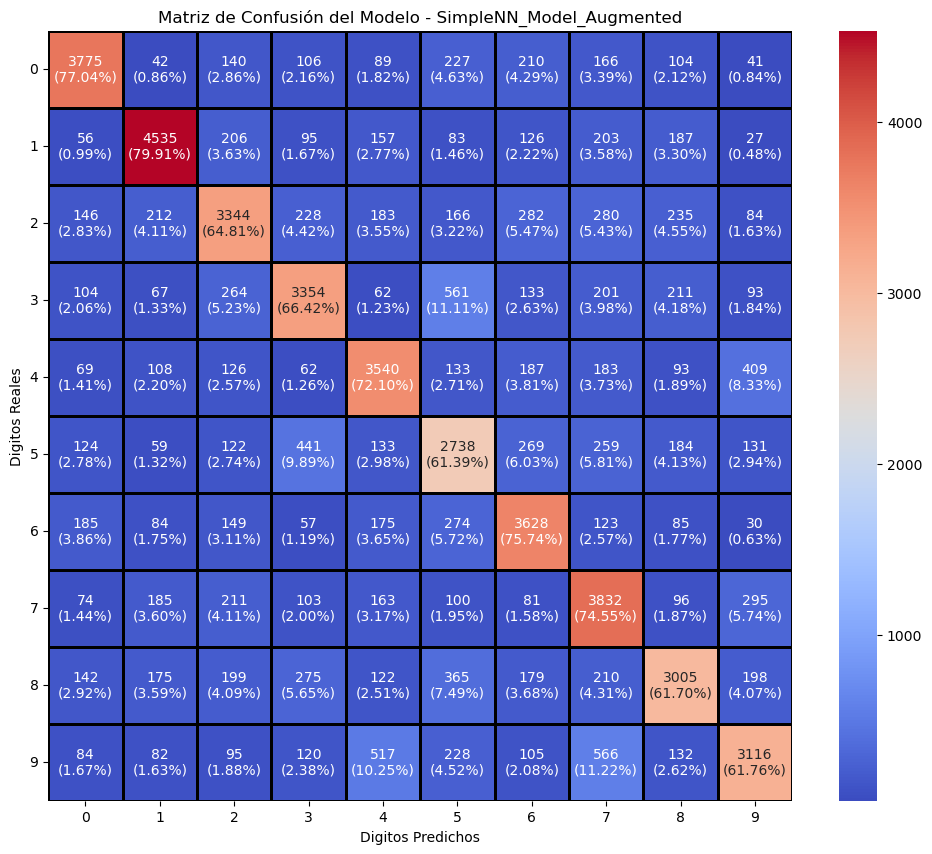

In [77]:
plot_confusion_matrix(y_test1a, test_preds1a, epochs1a, 'SimpleNN_Model_Augmented')

La matriz de confusión del `SimpleNN_Model` con datos aumentados revela que el modelo tiene dificultades significativas para diferenciar entre ciertos dígitos, particularmente entre el 9 y el 4. Esto es evidente por el alto número de confusiones entre estos dos dígitos, lo que sugiere que la arquitectura simple del modelo no es suficientemente robusta para captar las diferencias más sutiles en las características visuales entre estos números. Además, la precisión general de la clasificación para otros dígitos también muestra un desempeño subóptimo, con varios casos de confusión entre dígitos que tienen formas similares, lo que indica que el data augmentation no logró mejorar la capacidad del modelo para generalizar en estos casos.

#### Muestreo de Predicciones del Modelo

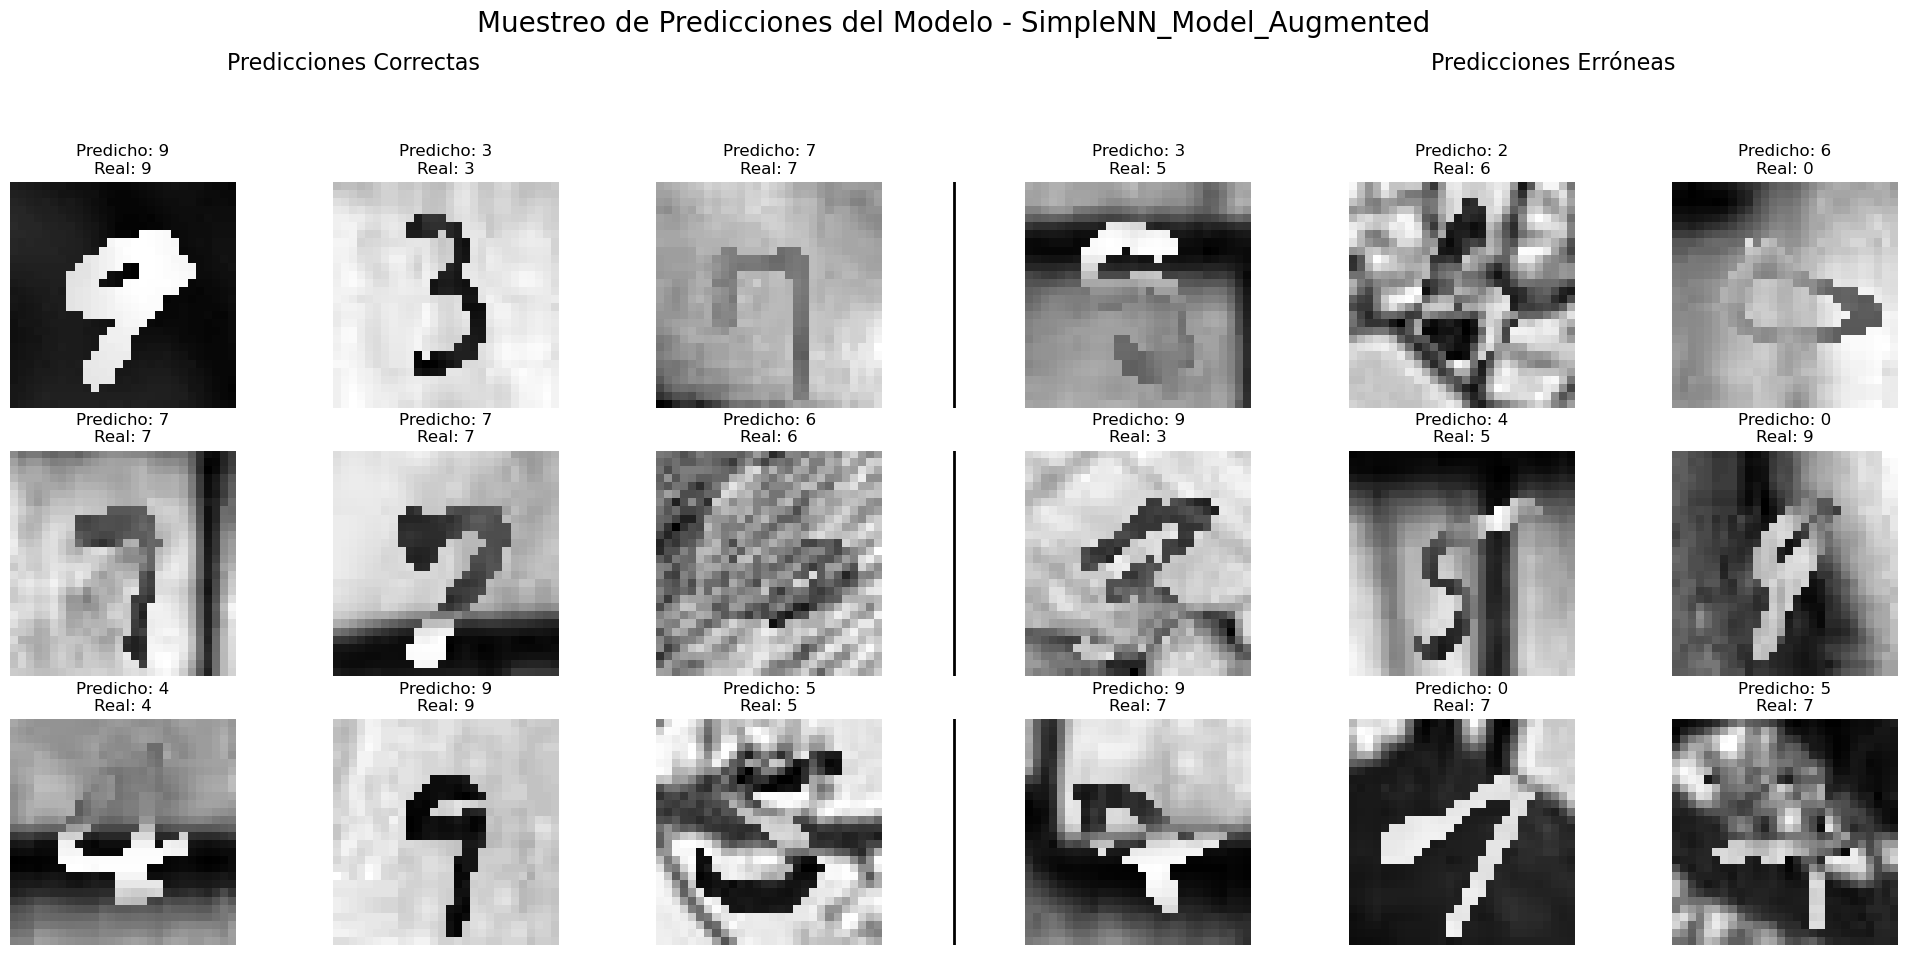

In [78]:
plot_predictions_sample(test_preds1a, y_test1a, X_test1a, epochs1a, 'SimpleNN_Model_Augmented')

El muestreo de predicciones para el modelo `SimpleNN_Model` con datos aumentados muestra una tendencia similar a lo observado en la matriz de confusión. Las predicciones correctas son precisas cuando el dígito está bien definido y no tiene elementos que puedan confundir al modelo, como sucede con los dígitos 8, 1, y 9. Sin embargo, el modelo enfrenta dificultades con imágenes que presentan ruido, rotaciones inusuales, o dígitos que se parecen a otros, como se evidencia en las predicciones erróneas. Por ejemplo, el dígito 8 se confunde varias veces con el 3 y el 5, y el dígito 7 se confunde con el 1 debido a su estructura delgada y alargada.

Estas confusiones reflejan las limitaciones del modelo al trabajar con datos aumentados que presentan variaciones mayores, lo que subraya la necesidad de arquitecturas más complejas, como las CNN, para manejar mejor estas situaciones.

#### Guardar el modelo

In [79]:
# Guardar el modelo entrenado
torch.save(model_simple_a.state_dict(), 'models/simple_model_augmentation.pth')

#### Comparación de Rendimiento del modelo con datos aumentados vs originales

En la comparación entre el modelo `SimpleNN_Model` entrenado con datos aumentados y el mismo modelo entrenado sin datos aumentados, se observa un comportamiento esperado. Similar a lo que ocurrió con el `CNN_Model1`, donde la adición de datos aumentados ayudó a mejorar ligeramente la precisión, en el caso del `SimpleNN_Model`, el rendimiento no solo mejoró, sino que incluso escalo un **3%** en mejoras.

El modelo sin datos aumentados logró una precisión de prueba de alrededor del **66%**, mientras que con los datos aumentados, la precisión subió a aproximadamente a **69%**. Además, la matriz de confusión mostró una disminución en las confusiones entre ciertos dígitos, como el 9 y el 4, lo que sugiere que el aumento de variabilidad en los datos, ayuda al modelo a generalizar mejor.

Este resultado puede deberse a la simplicidad inherente de la arquitectura del `SimpleNN_Model`, que no es del todo capaz de manejar adecuadamente la mayor complejidad introducida por las transformaciones en los datos. En contraste con las CNN, que tienen múltiples capas para aprender características jerárquicas, este modelo simple puede haber sido "sobrecargado" con la variabilidad adicional sin tener la capacidad de aprender patrones más complejos que le permitan beneficiarse del aumento de datos.

## Modelos con otros algoritmos

De los algoritmos considerados, se seleccionará el **Support Vector Machine (SVM)** para esta tarea. La razón principal para elegir SVM es su capacidad para manejar problemas de clasificación en datasets de alta dimensionalidad, como es el caso con las imágenes de dígitos. 

SVM es efectivo en espacios de alta dimensión y es especialmente útil cuando el número de dimensiones supera el número de muestras, algo que puede ocurrir en problemas de clasificación de imágenes. Además, SVM utiliza un margen máximo para separar las clases, lo que puede resultar en un modelo más robusto y menos propenso al overfitting en comparación con otros algoritmos como K-Nearest Neighbors (KNN). 

Finalmente, SVM es una buena opción para comparar con modelos de redes neuronales porque ofrece un enfoque completamente diferente: mientras las redes neuronales se entrenan mediante retropropagación y optimización de pesos, SVM se centra en encontrar un hiperplano óptimo para la clasificación, lo que permite analizar cómo se comporta este método en comparación con las técnicas de deep learning.

### Modelo SVM con datos originales

Dado que trabajar con un DataFrame tan grande podría ser muy costoso en términos de tiempo y recursos, una opción viable es tomar una muestra equilibrada. A continuación se toma una muestra de 1000 registros con 100 muestras por cada dígito y luego entrenar el modelo SVM utilizando esa muestra.

In [10]:
# Cargar el conjunto de datos de entrenamiento original
train_df = pd.read_csv('data/train.csv', dtype=np.float32)
test_df = pd.read_csv('data/test.csv', dtype=np.float32)

# Tomar una muestra de 1000 registros, 100 por cada dígito (label)
sample_df_svm = train_df.groupby('label', group_keys=False).apply(lambda x: x.sample(n=100, random_state=42)).reset_index(drop=True)

# Separar características (pixeles) y etiquetas (label) en el DataFrame de la muestra
X_train_svm = sample_df_svm.drop(columns=['label'])
y_train_svm = sample_df_svm['label']

# Puedes hacer lo mismo con test_df para asegurar una muestra balanceada si es necesario
# Aquí asumimos que test_df ya está balanceado y no se requiere tomar muestra
X_test_svm = test_df.drop(columns=['label'])
y_test_svm = test_df['label']

# Estandarizar las características (es una buena práctica para SVM)
scaler_svm = StandardScaler()
X_train_svm = scaler_svm.fit_transform(X_train_svm)
X_test_svm = scaler_svm.transform(X_test_svm)

# Crear el modelo SVM (puedes ajustar los hiperparámetros como 'kernel', 'C', 'gamma', etc.)
model_svm = SVC(kernel='linear', C=1.0, random_state=42)

# Entrenar el modelo con la muestra
model_svm.fit(X_train_svm, y_train_svm)

# Generar predicciones
y_pred_svm = model_svm.predict(X_test_svm)

# Calcular y mostrar el accuracy
accuracy_svm = accuracy_score(y_test_svm, y_pred_svm)
print(f'Accuracy del modelo SVM con muestra: {accuracy_svm:.4f}')

Accuracy del modelo SVM con muestra: 0.1643


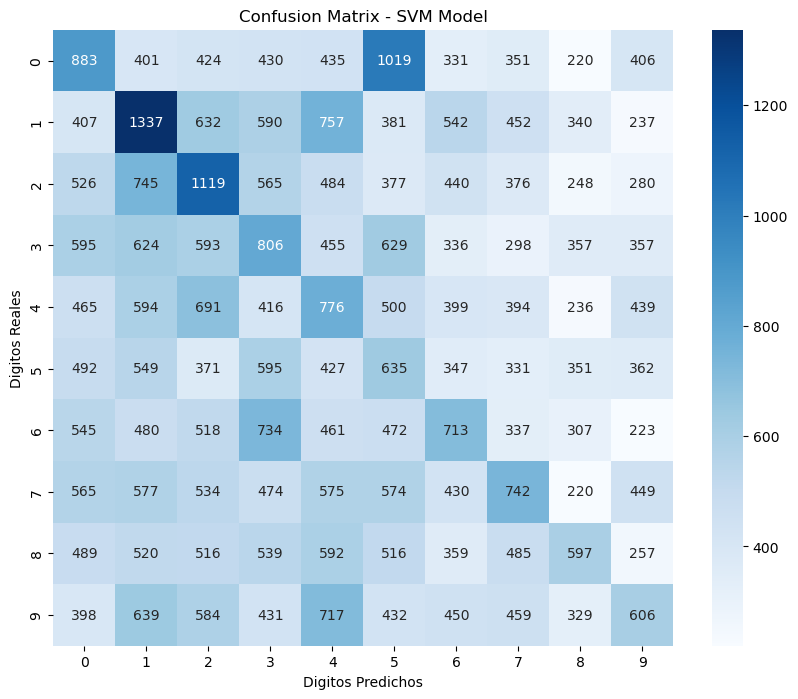

In [12]:
# Generar la matriz de confusión
cm_svm = confusion_matrix(y_test_svm, y_pred_svm)

# Crear la figura de la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))

# Configurar etiquetas y título
plt.xlabel('Digitos Predichos')
plt.ylabel('Digitos Reales')
plt.title('Confusion Matrix - SVM Model')

# Mostrar la gráfica
plt.show()

### Modelo SVM con datos aumentados

Se sigue con la misma metodologia de tomar una muestra de 100 imagenes por digito.

In [13]:
# Cargar el conjunto de datos de entrenamiento aumentado
augmented_train_df = pd.read_csv('data/train_augmented.csv', dtype=np.float32)
test_df = pd.read_csv('data/test.csv', dtype=np.float32)

# Tomar una muestra de 1000 registros, 100 por cada dígito (label) de los datos aumentados
sample_df_svm_augmented = augmented_train_df.groupby('label', group_keys=False).apply(lambda x: x.sample(n=100, random_state=42)).reset_index(drop=True)

# Separar características (pixeles) y etiquetas (label) en el DataFrame de la muestra
X_train_svm_augmented = sample_df_svm_augmented.drop(columns=['label'])
y_train_svm_augmented = sample_df_svm_augmented['label']

# Asumimos que test_df ya está balanceado y no se requiere tomar muestra
X_test_svm = test_df.drop(columns=['label'])
y_test_svm = test_df['label']

# Estandarizar las características
scaler_svm = StandardScaler()
X_train_svm_augmented = scaler_svm.fit_transform(X_train_svm_augmented)
X_test_svm = scaler_svm.transform(X_test_svm)

# Crear y entrenar el modelo SVM con los datos aumentados
model_svm_augmented = SVC(kernel='linear', C=1.0, random_state=42)
model_svm_augmented.fit(X_train_svm_augmented, y_train_svm_augmented)

# Generar predicciones
y_pred_svm_augmented = model_svm_augmented.predict(X_test_svm)

# Calcular y mostrar el accuracy
accuracy_svm_augmented = accuracy_score(y_test_svm, y_pred_svm_augmented)
print(f'Accuracy del modelo SVM con datos aumentados: {accuracy_svm_augmented:.4f}')

Accuracy del modelo SVM con datos aumentados: 0.1754


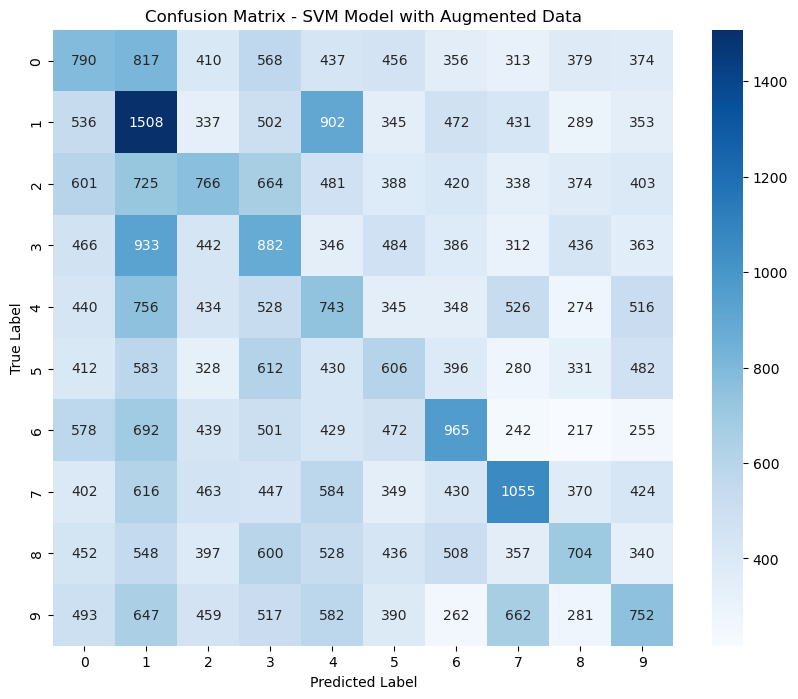

In [14]:
# Generar la matriz de confusión
cm_svm_augmented = confusion_matrix(y_test_svm, y_pred_svm_augmented)

# Crear la figura de la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(cm_svm_augmented, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))

# Configurar etiquetas y título
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - SVM Model with Augmented Data')

# Mostrar la gráfica
plt.show()

### Comparativa